In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from multiprocessing import cpu_count, Pool

In [2]:
tr = pd.read_pickle('../data/train.pkl')
tr_log = pd.read_pickle('../data/train_log.pkl')

In [5]:
def plt_fft(f):
    N = f.shape[0]
    # 高速フーリエ変換(FFT)
    F = np.fft.fft(f)
    # FFT結果（複素数）を絶対値に変換
    F_abs = np.abs(F)
    # 振幅を元に信号に揃える
    F_abs_amp = F_abs / N * 2 # 交流成分はデータ数で割って2倍する
    F_abs_amp[0] = F_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

    # グラフ表示（データ数の半分の周期を表示）
    plt.plot(F_abs_amp[:int(N/2)+1])
    return

def plt_obj(oid, pb):
    df = tr_log[(tr_log.object_id==oid) & (tr_log.passband==pb)]
    plt_fft(df.flux.values)

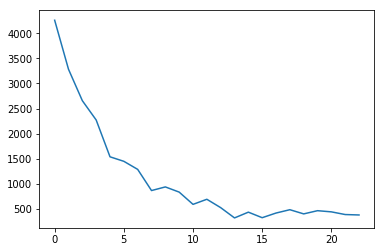

In [15]:
plt_obj(133773, 3)

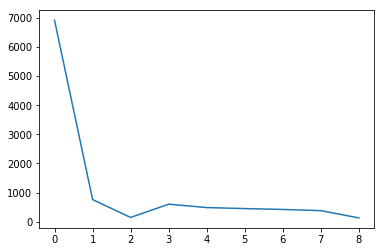

In [14]:
plt_obj(17991828, 3)

100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


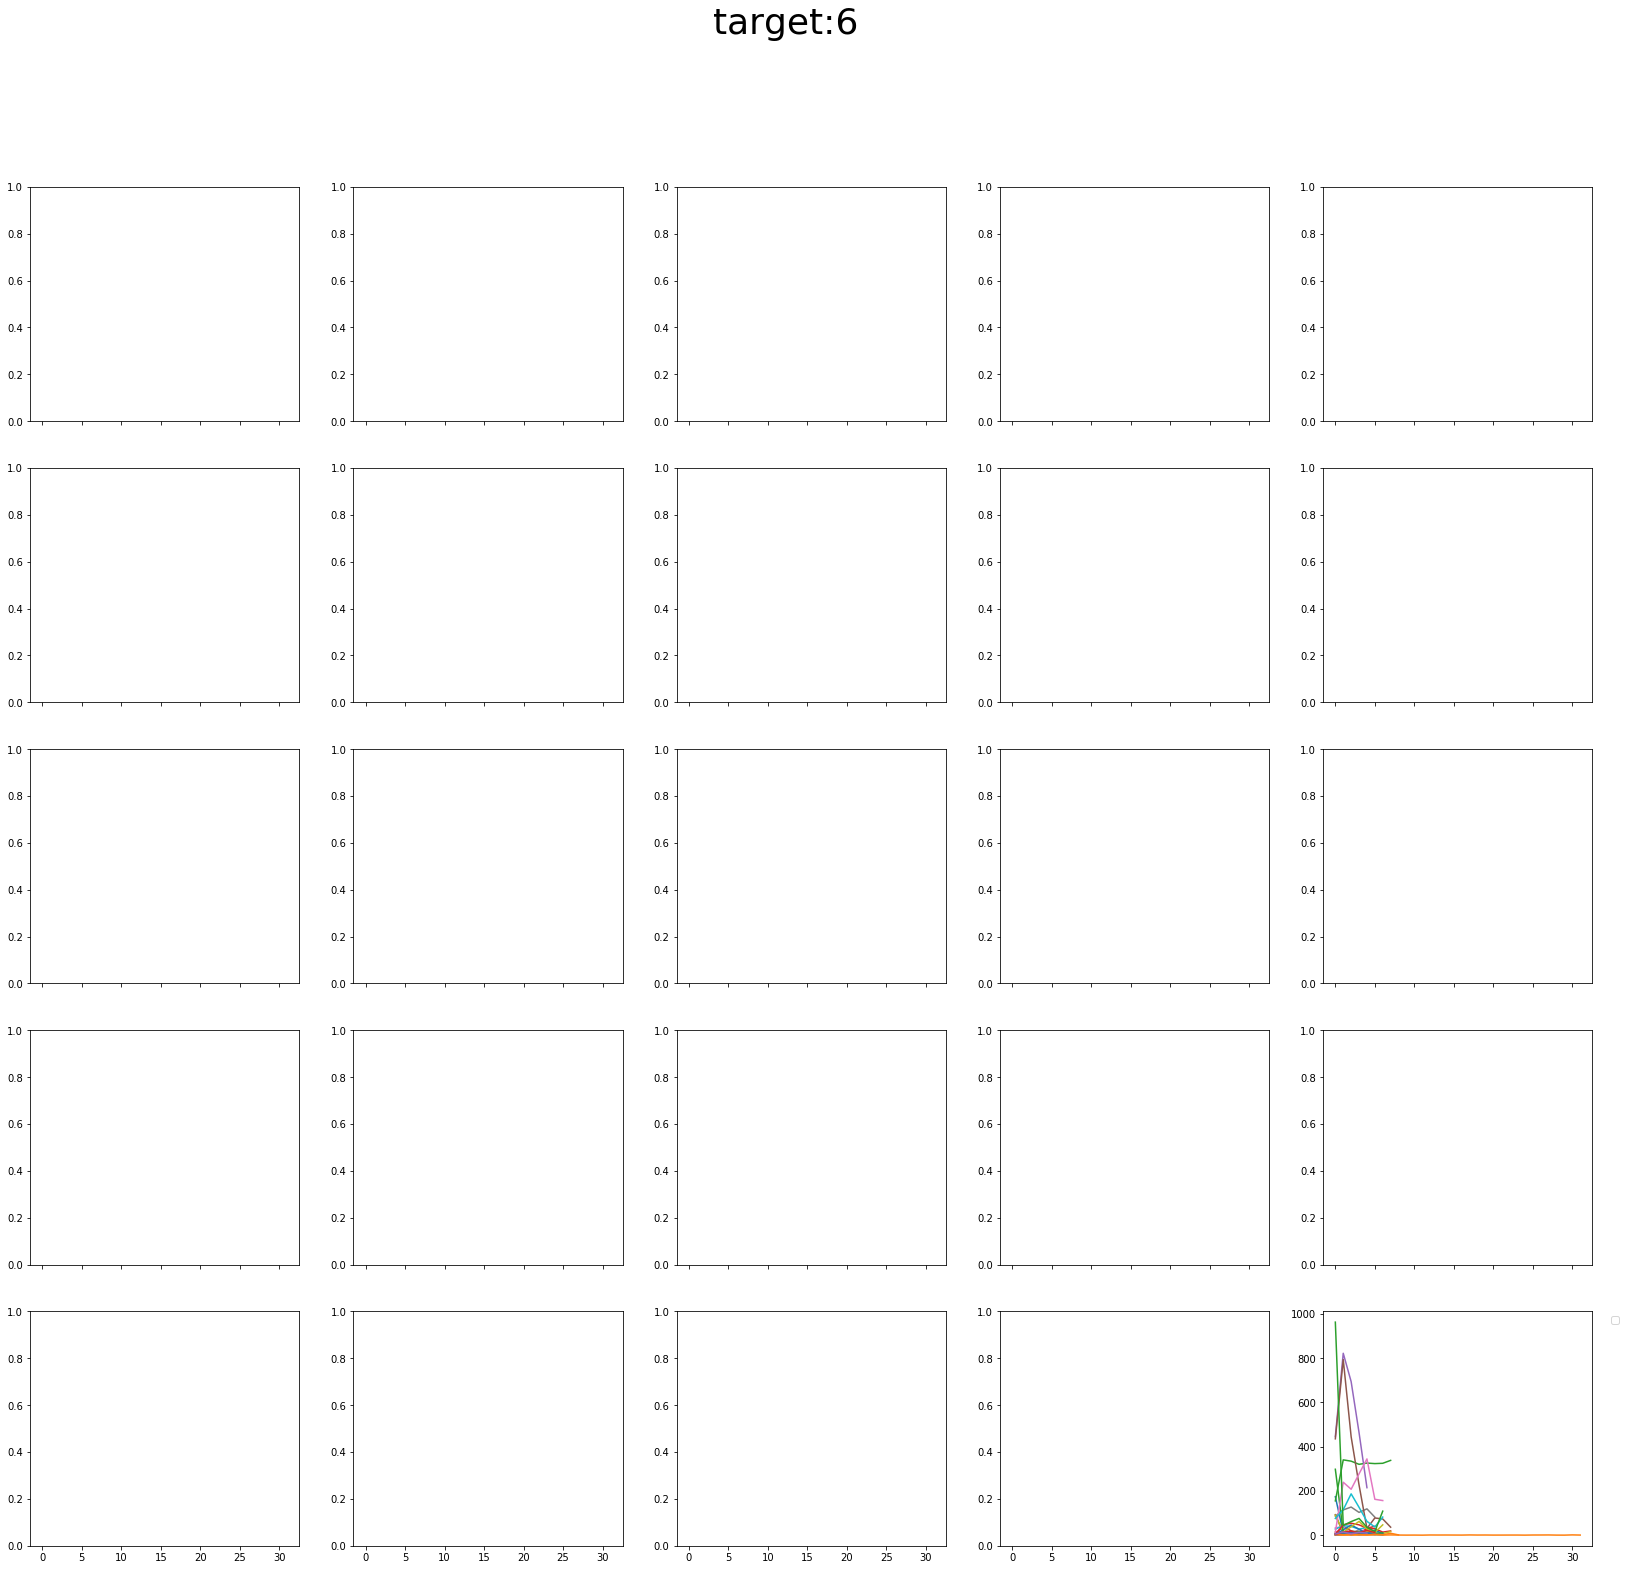

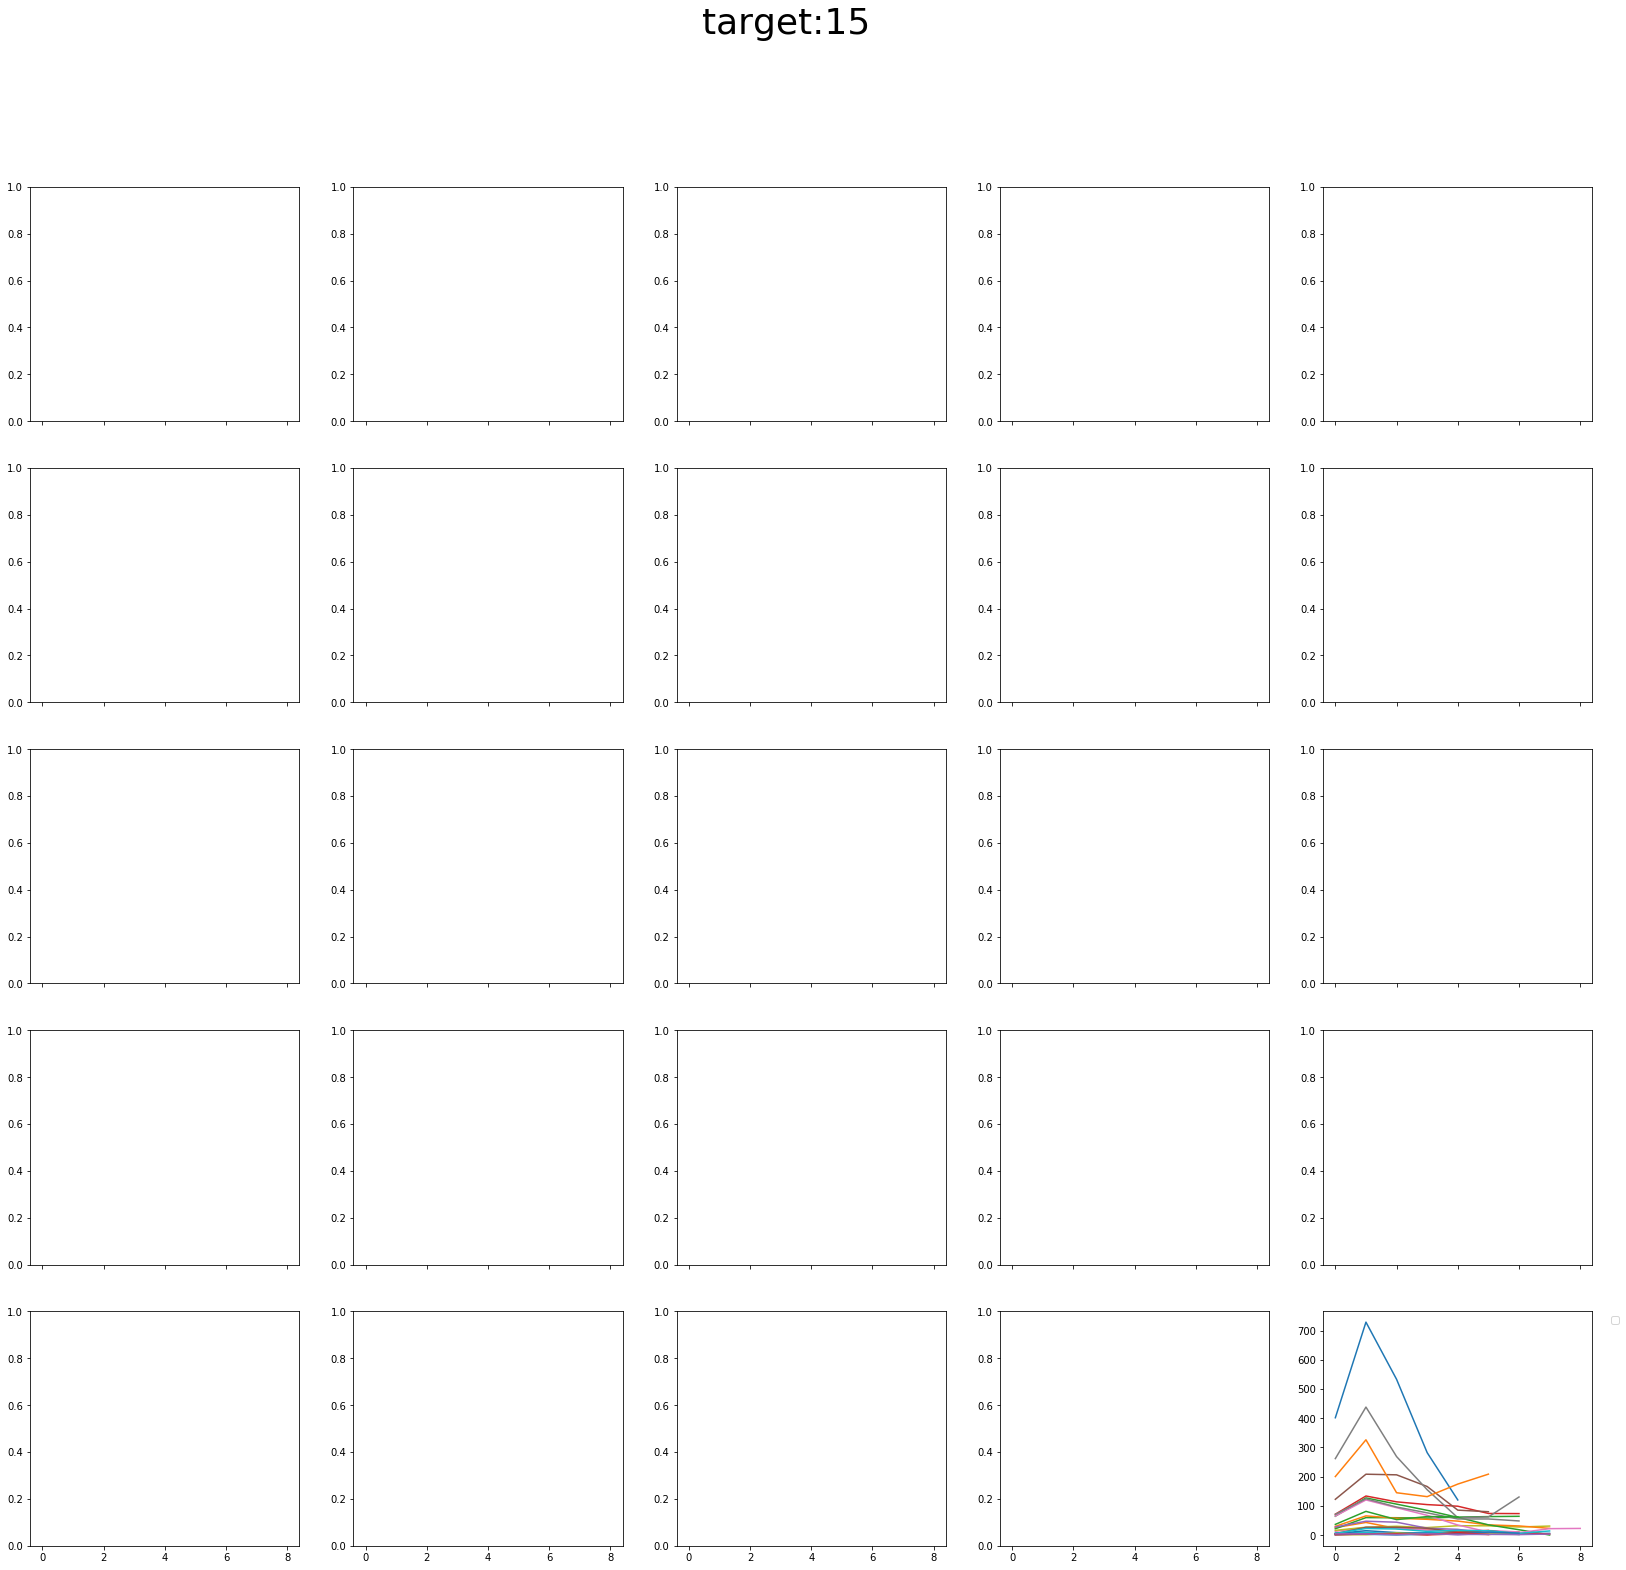

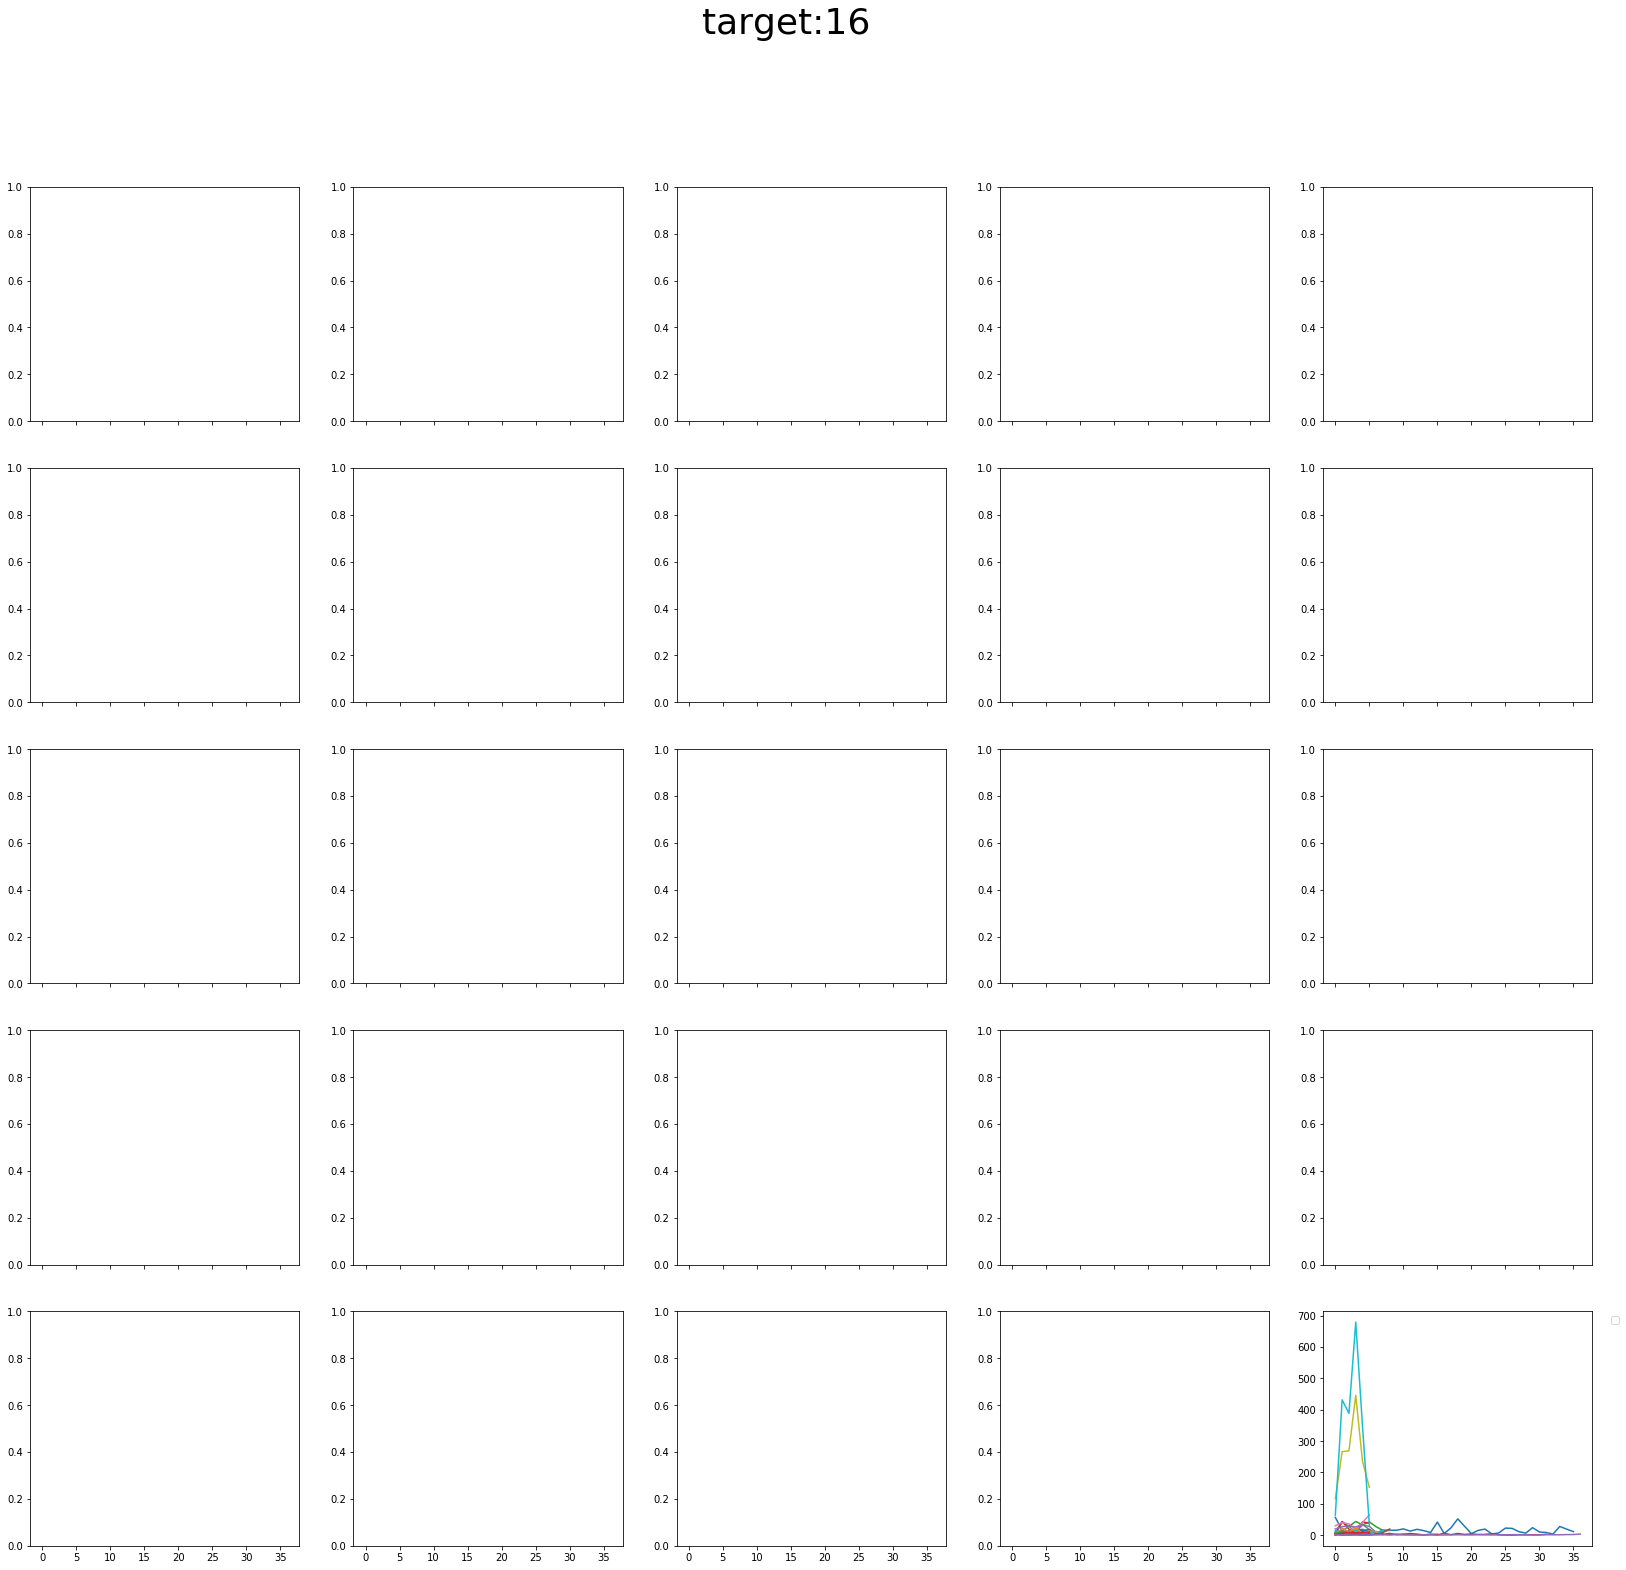

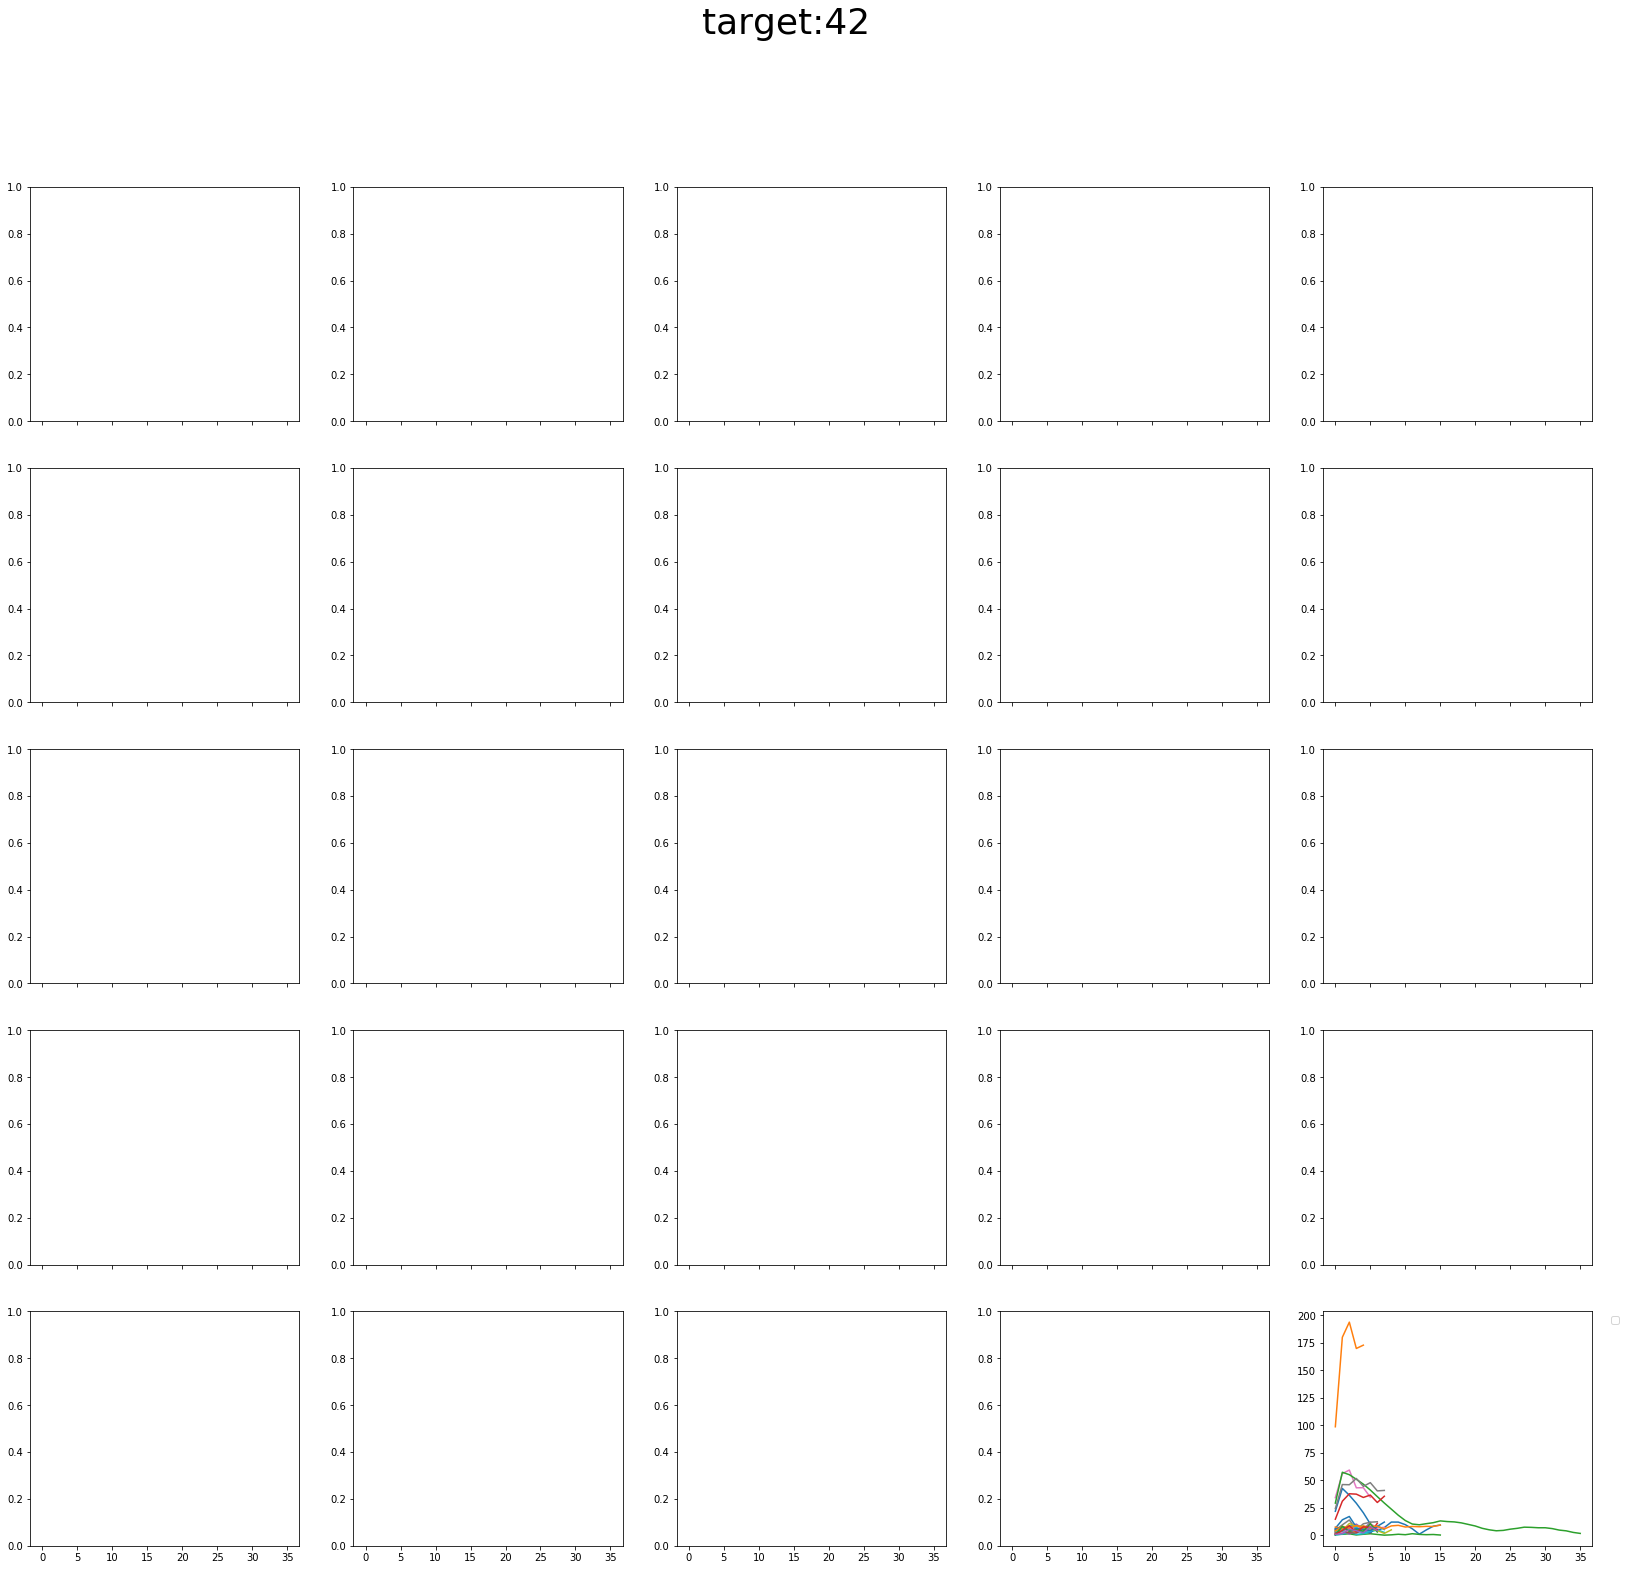

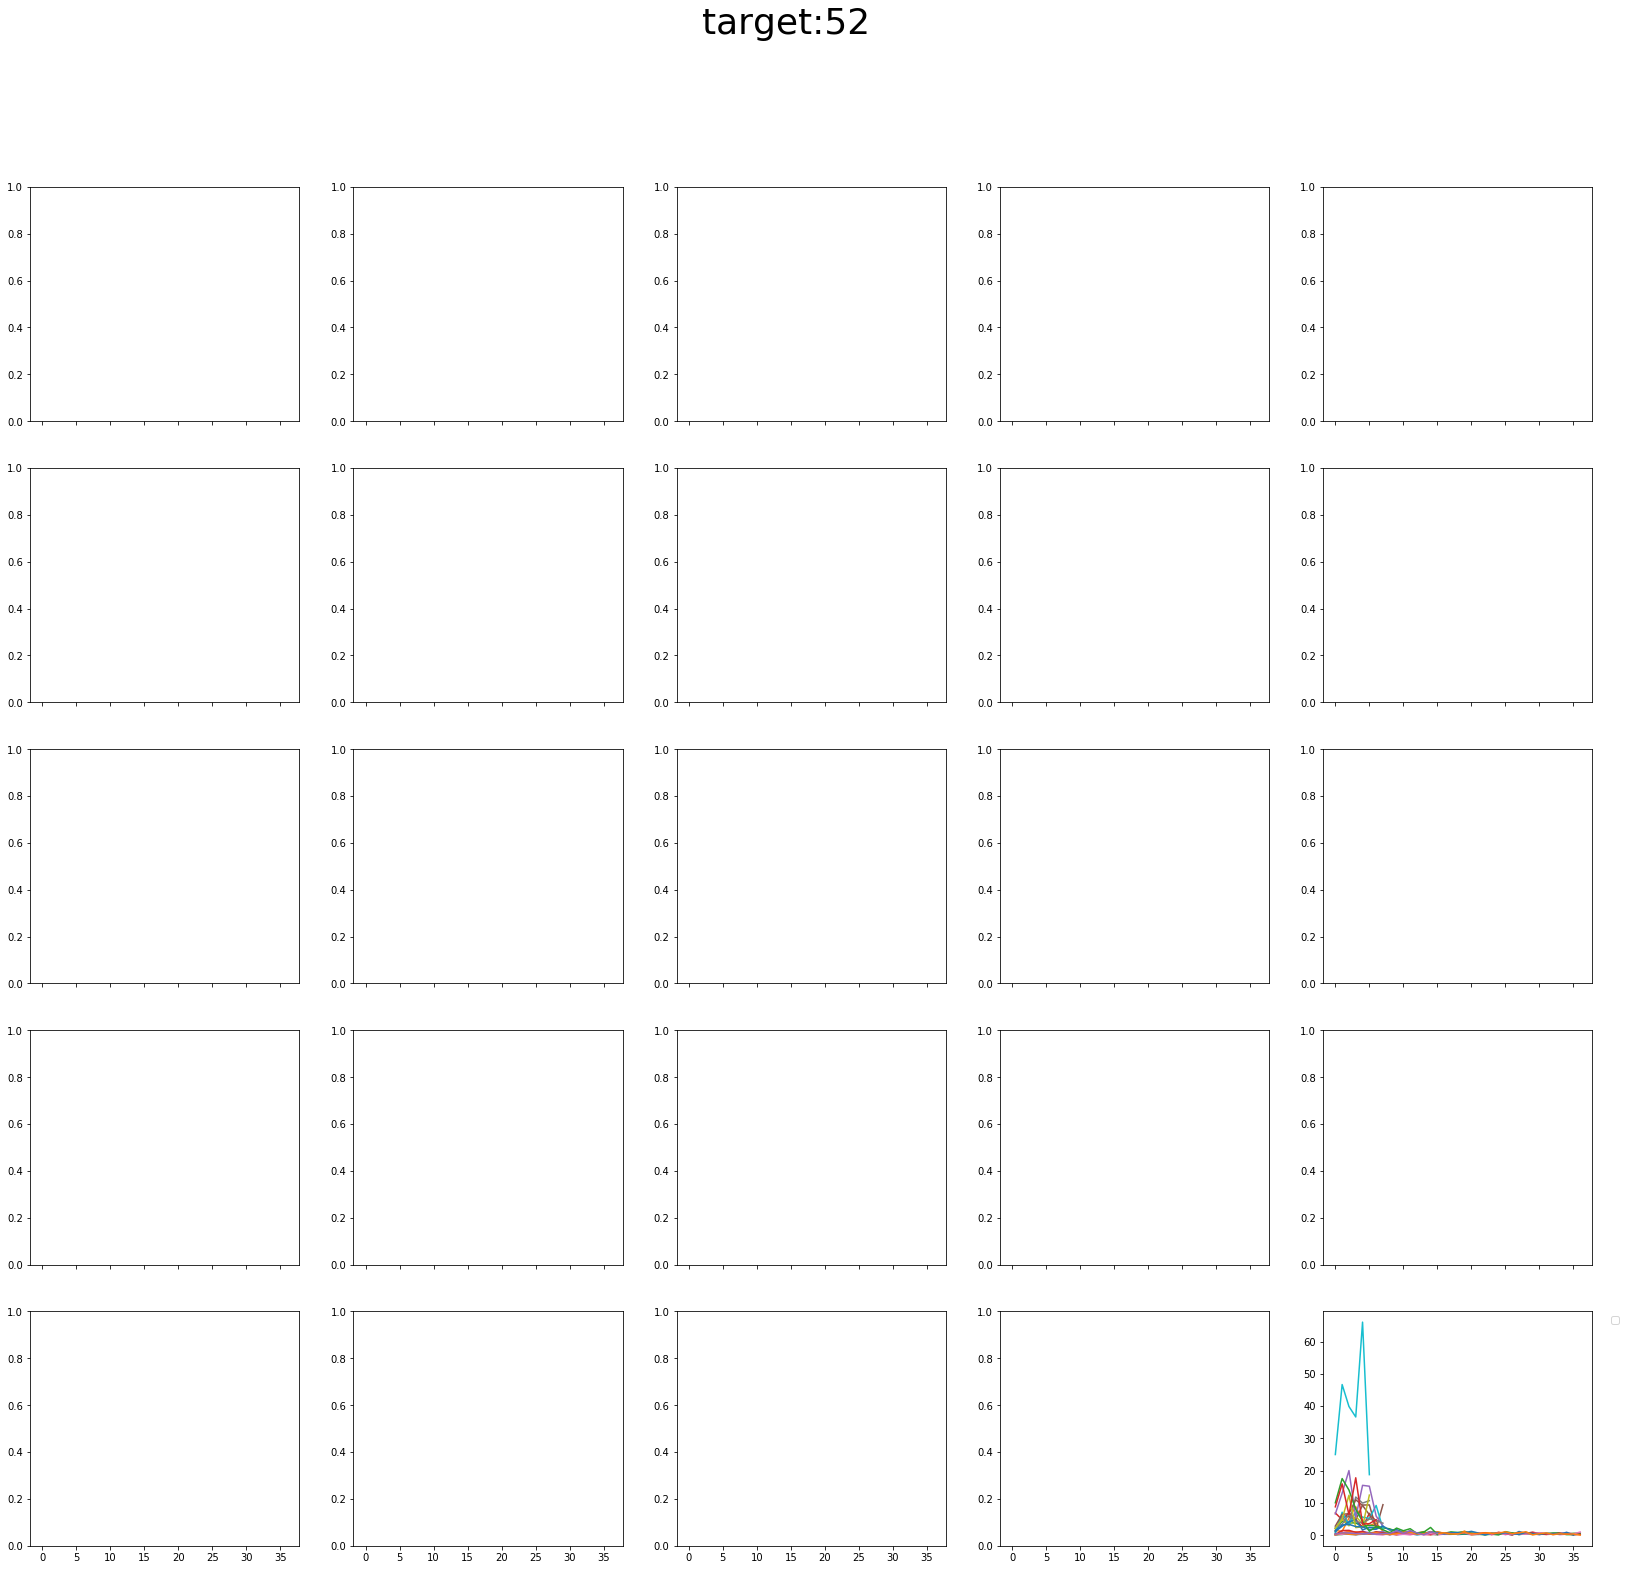

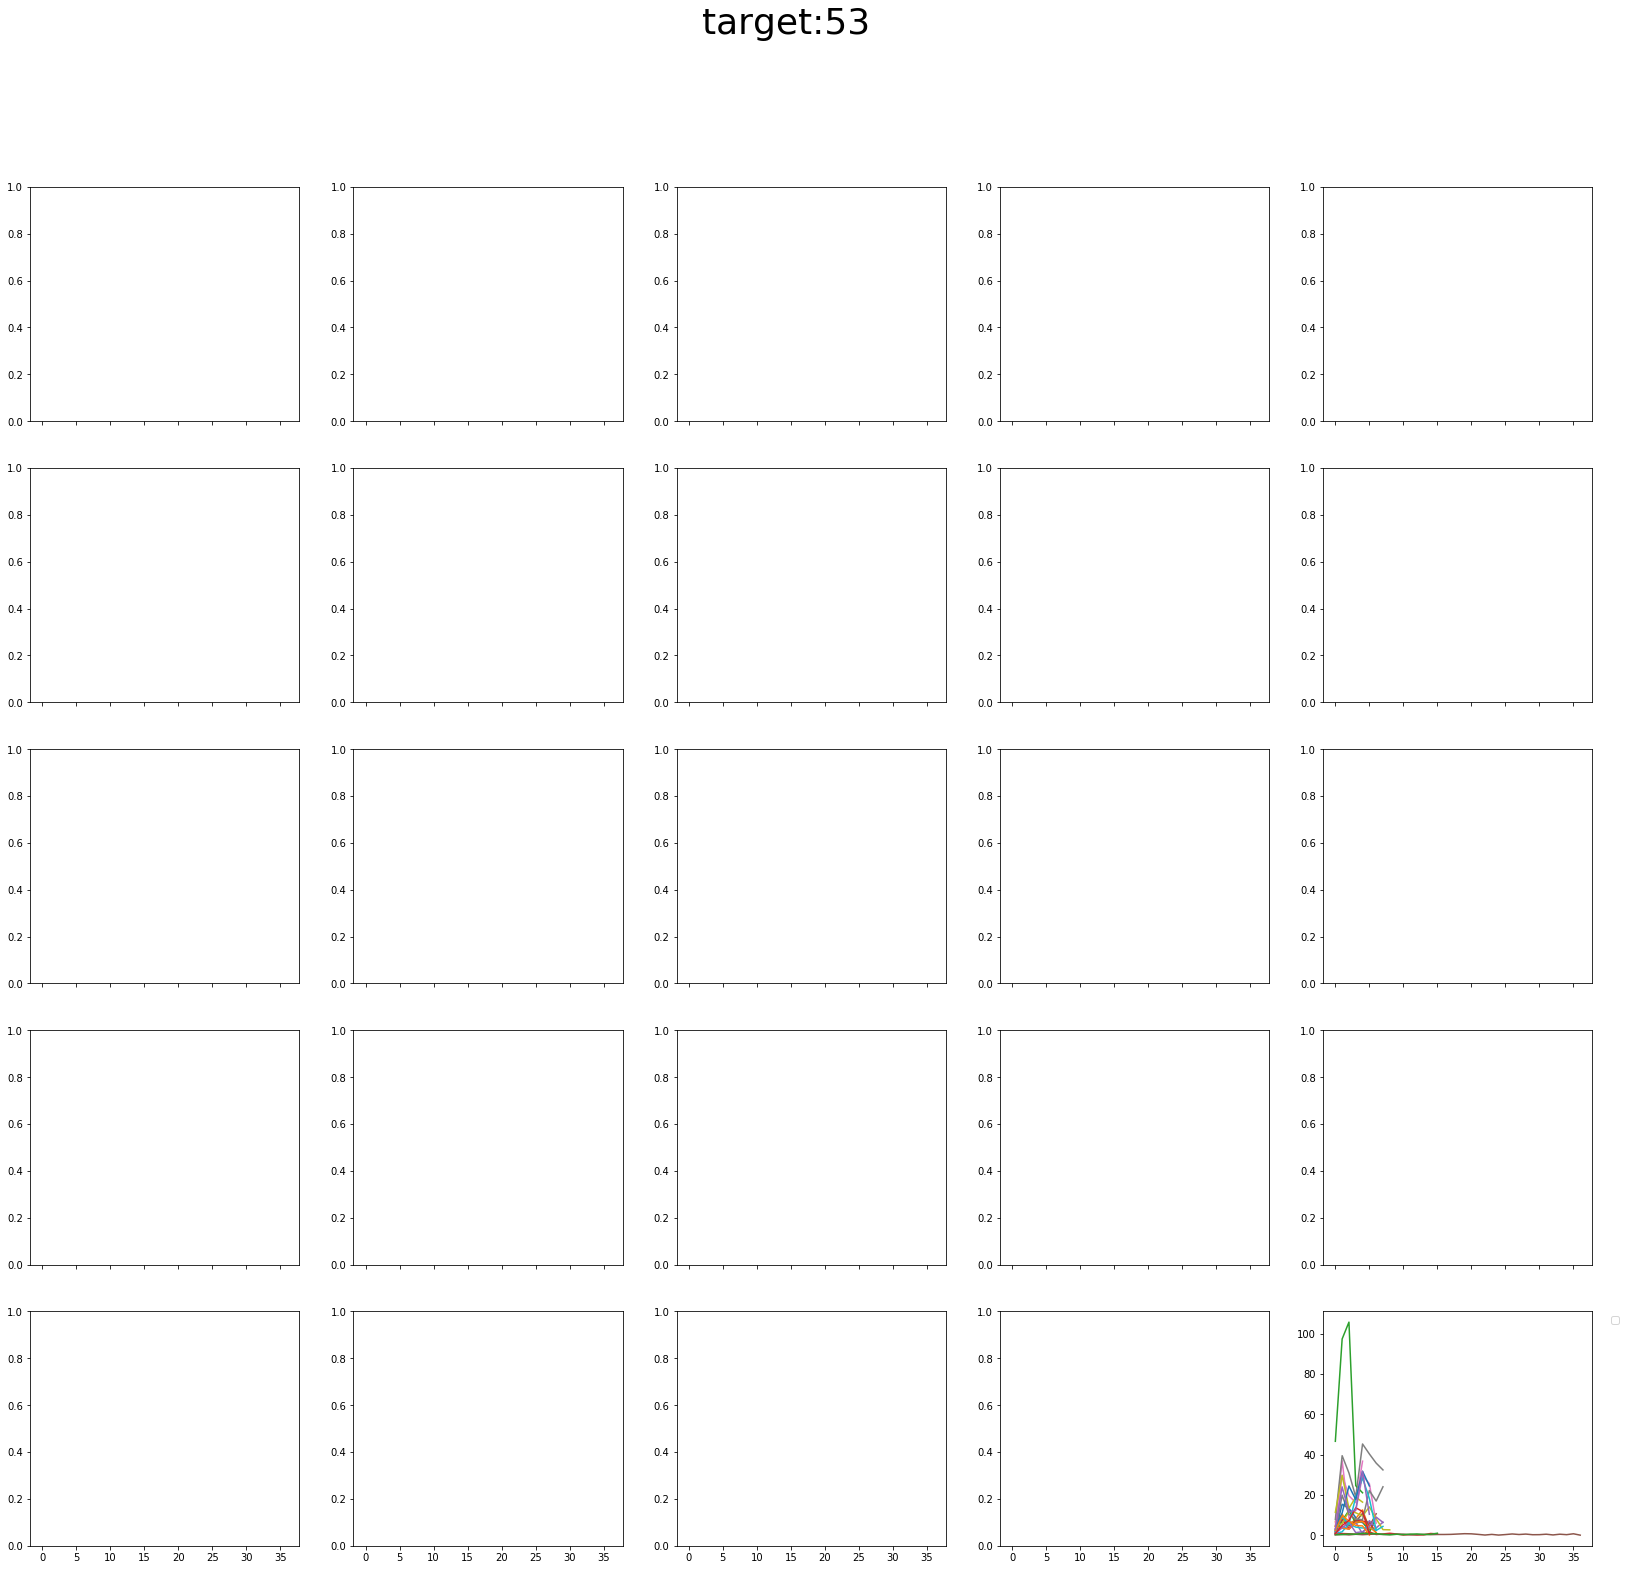

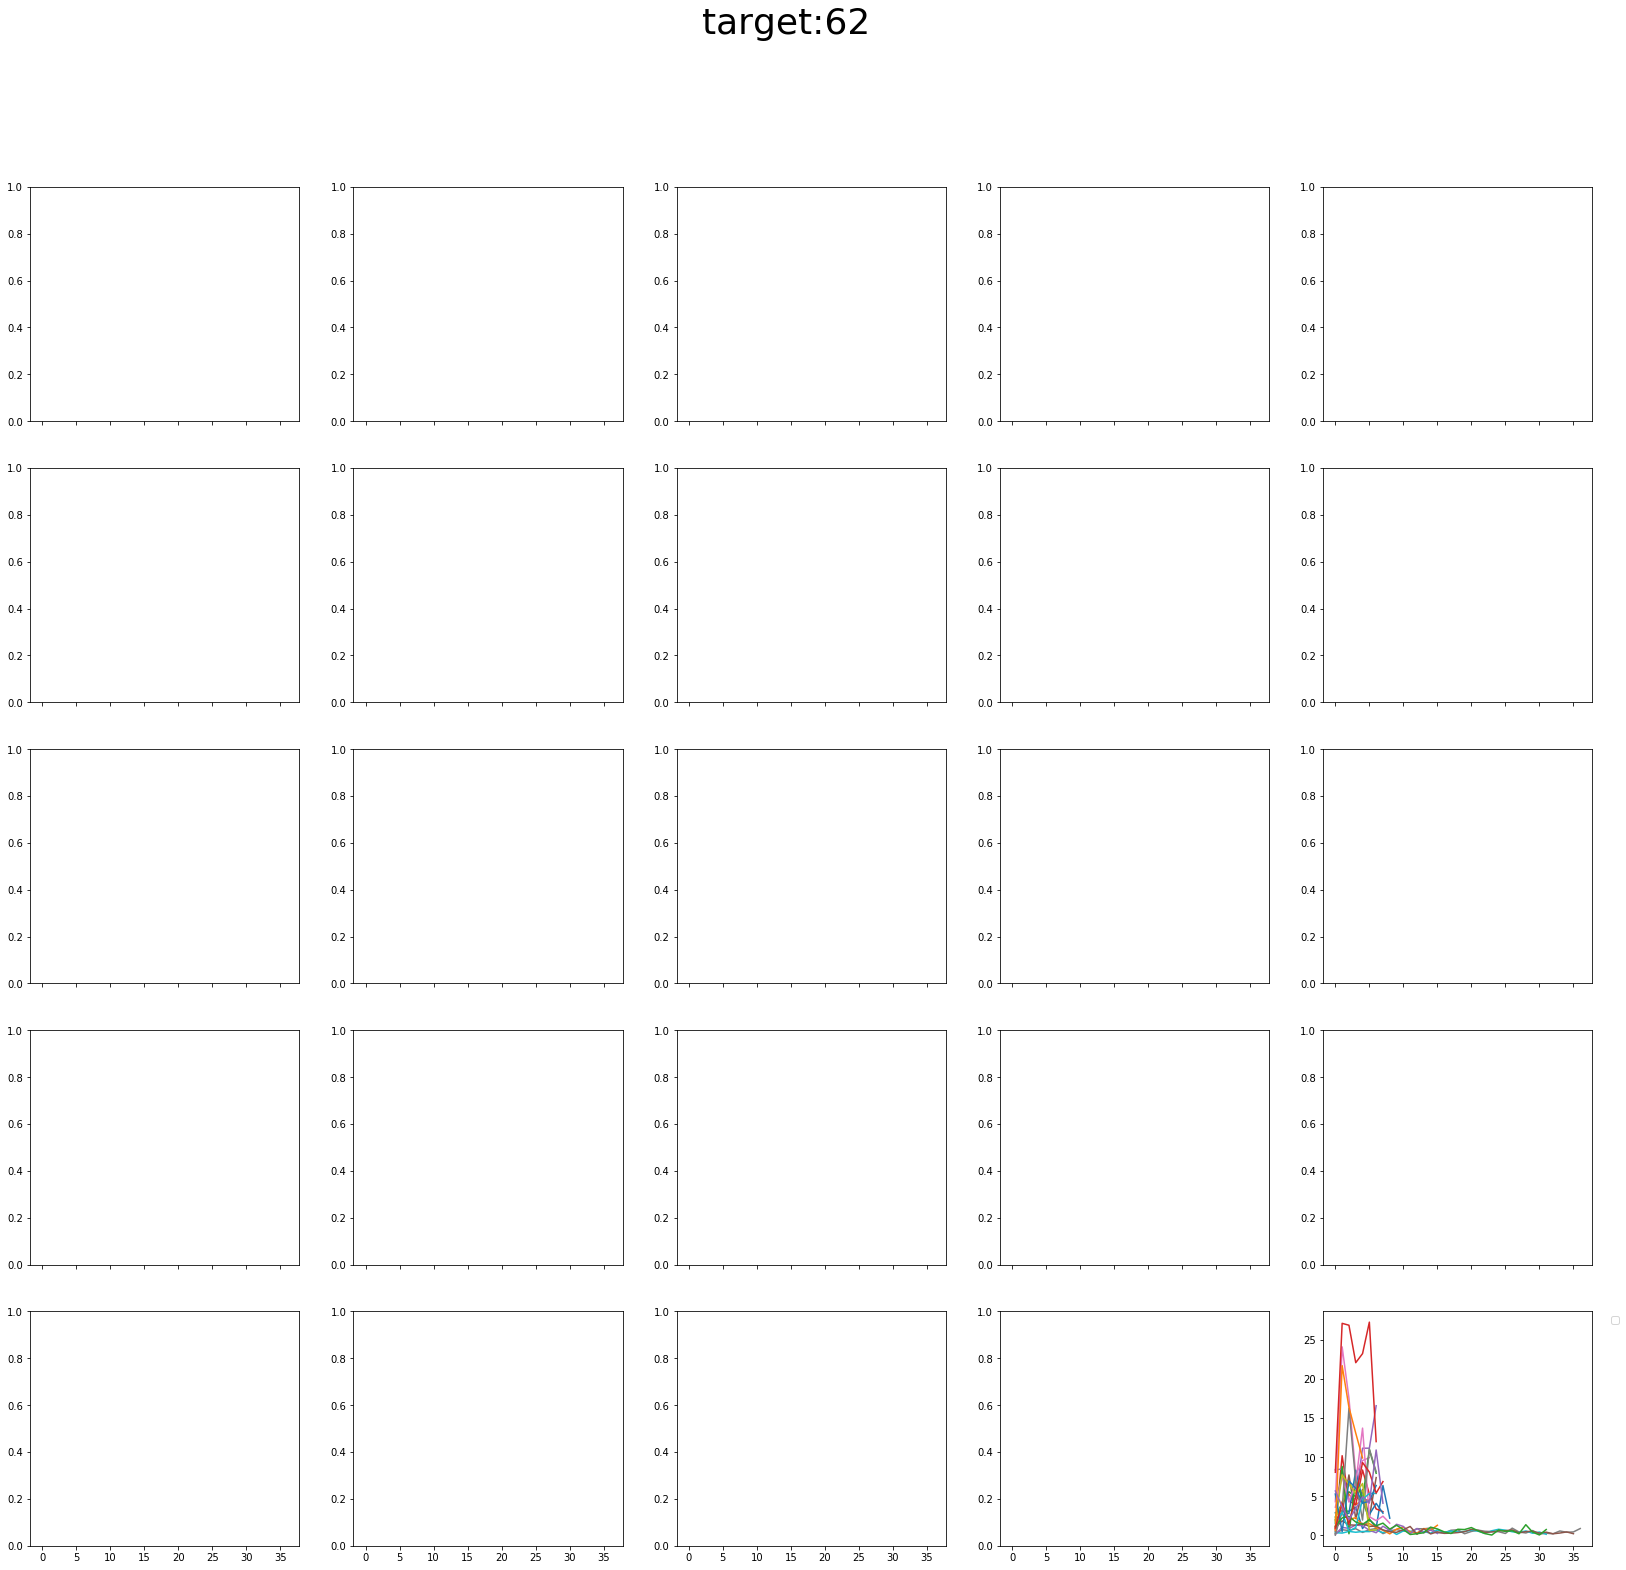

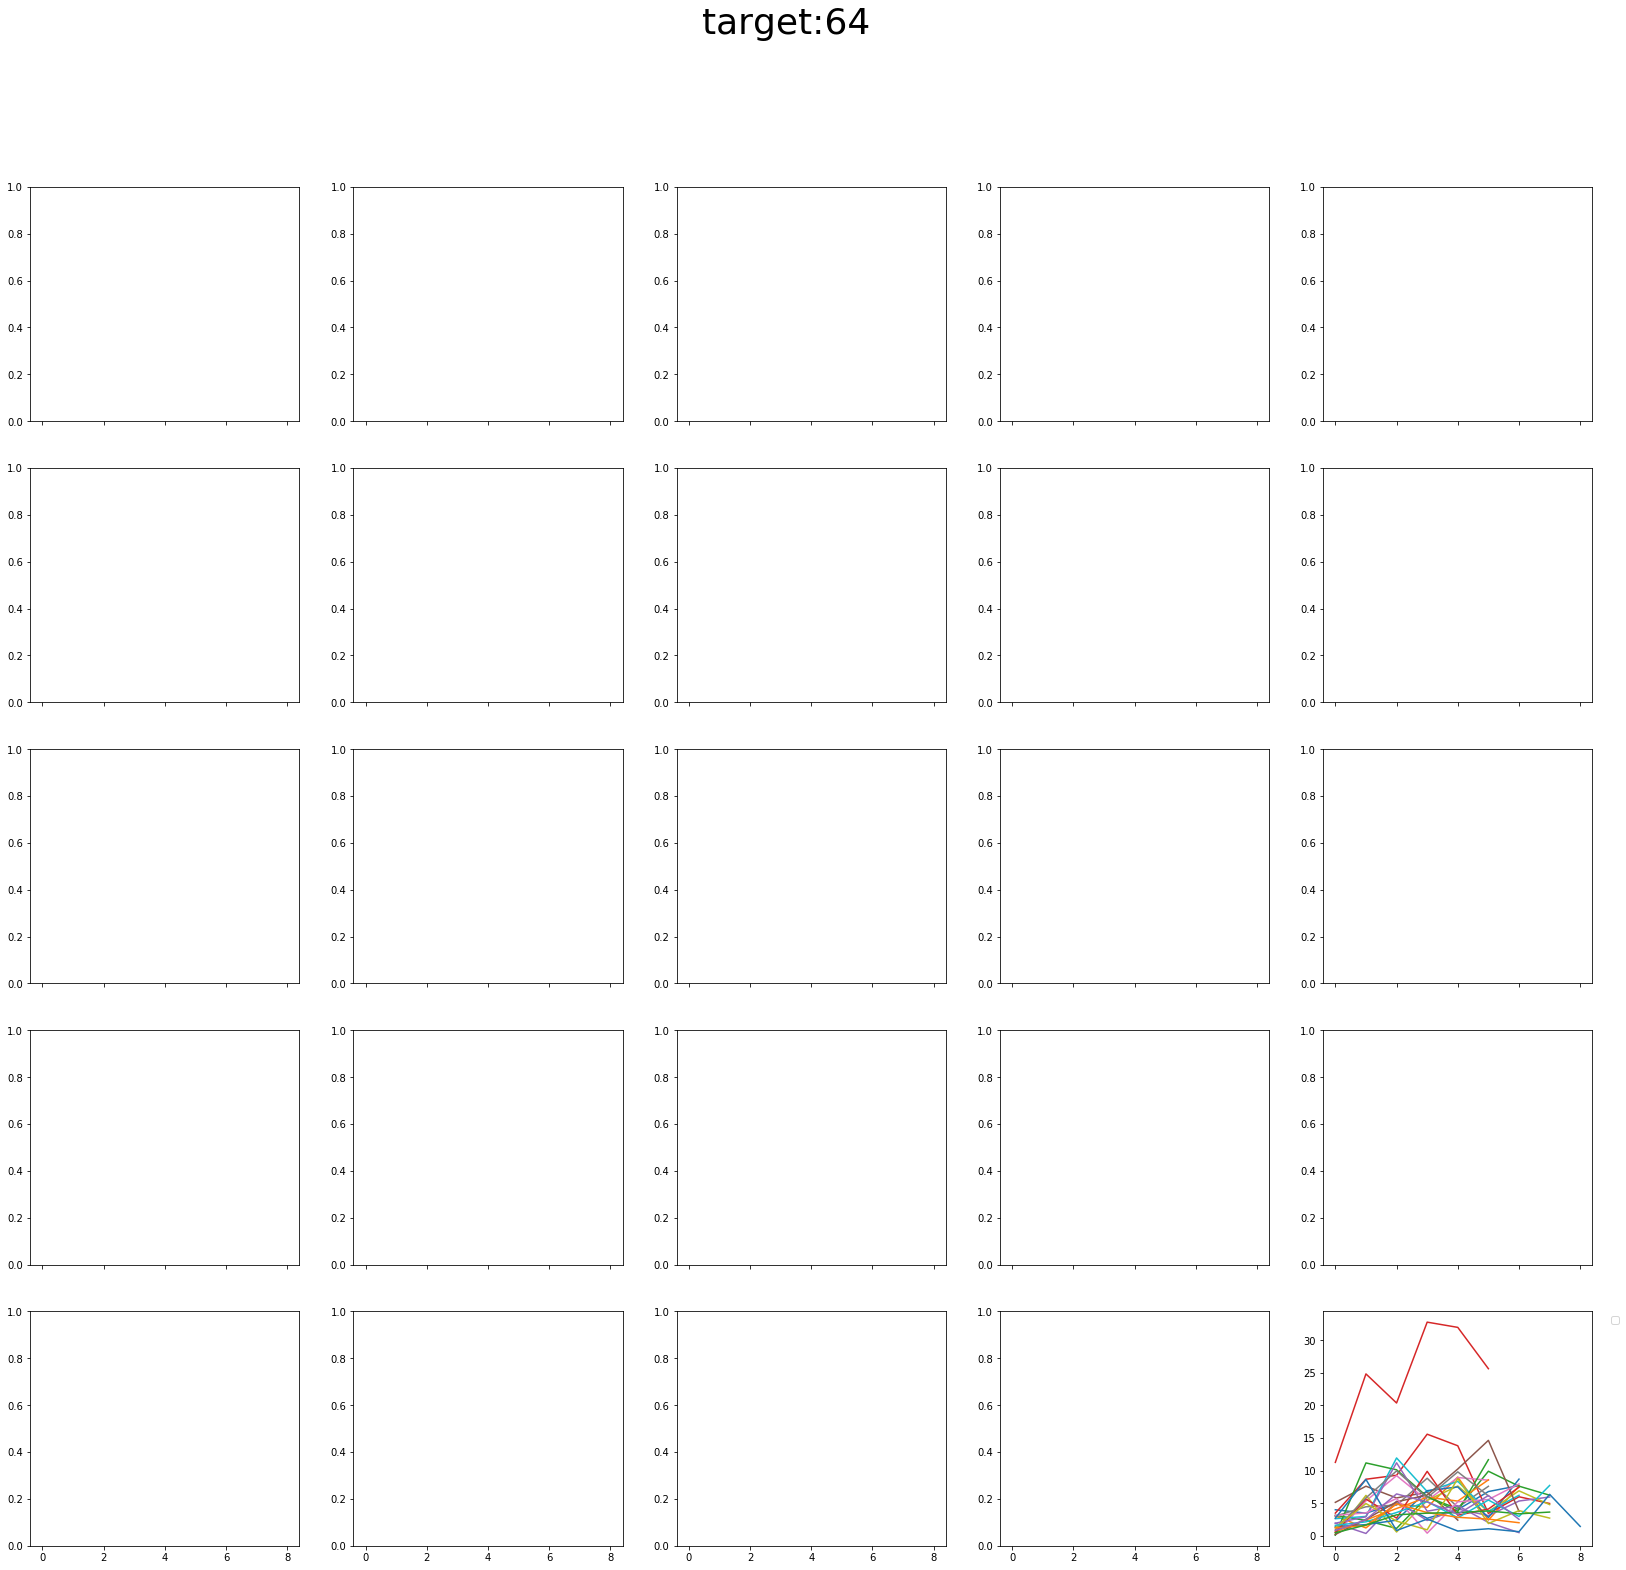

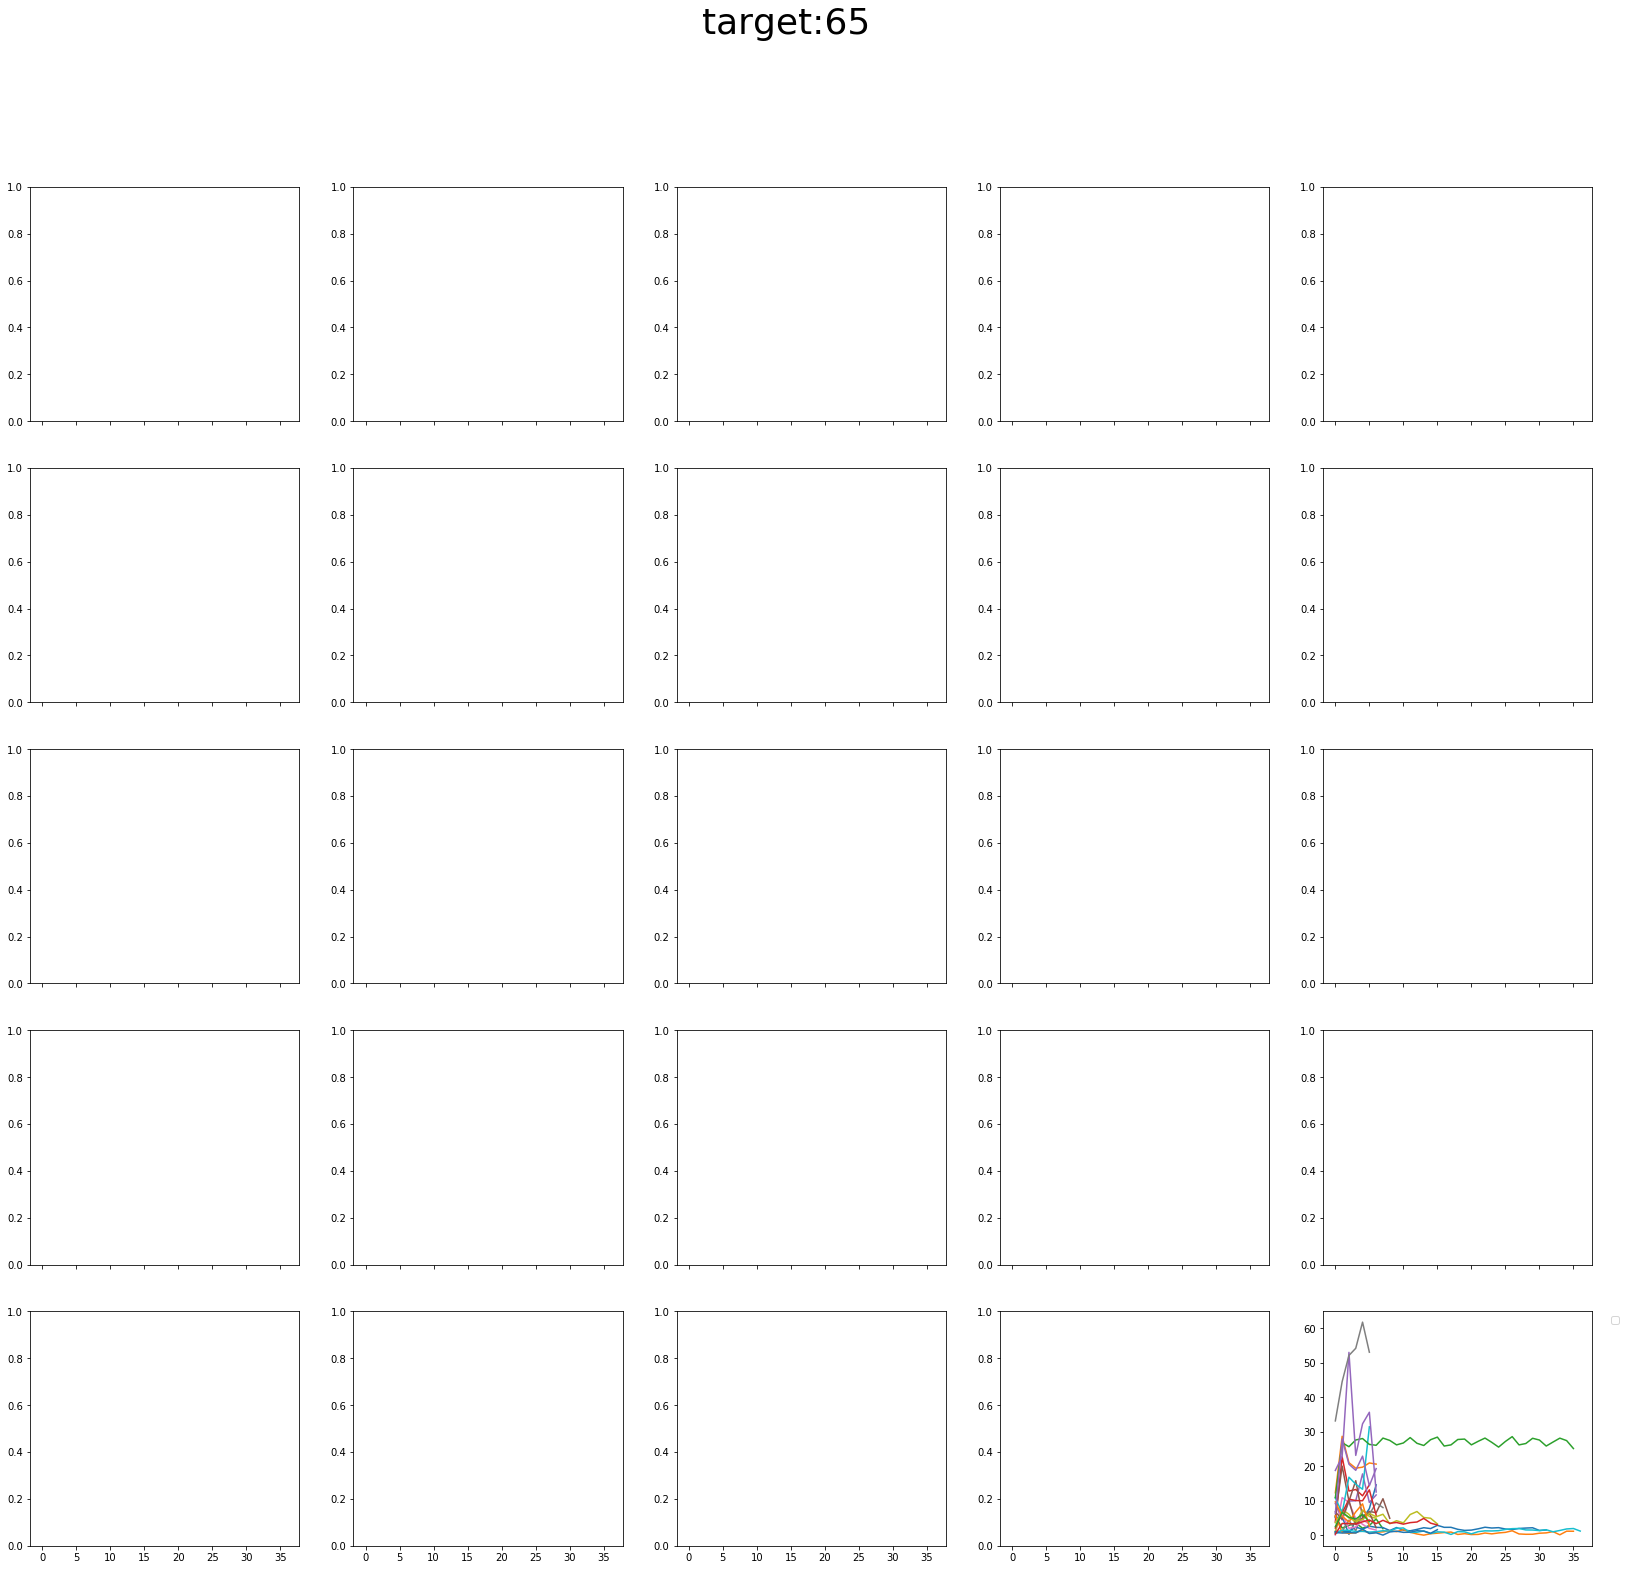

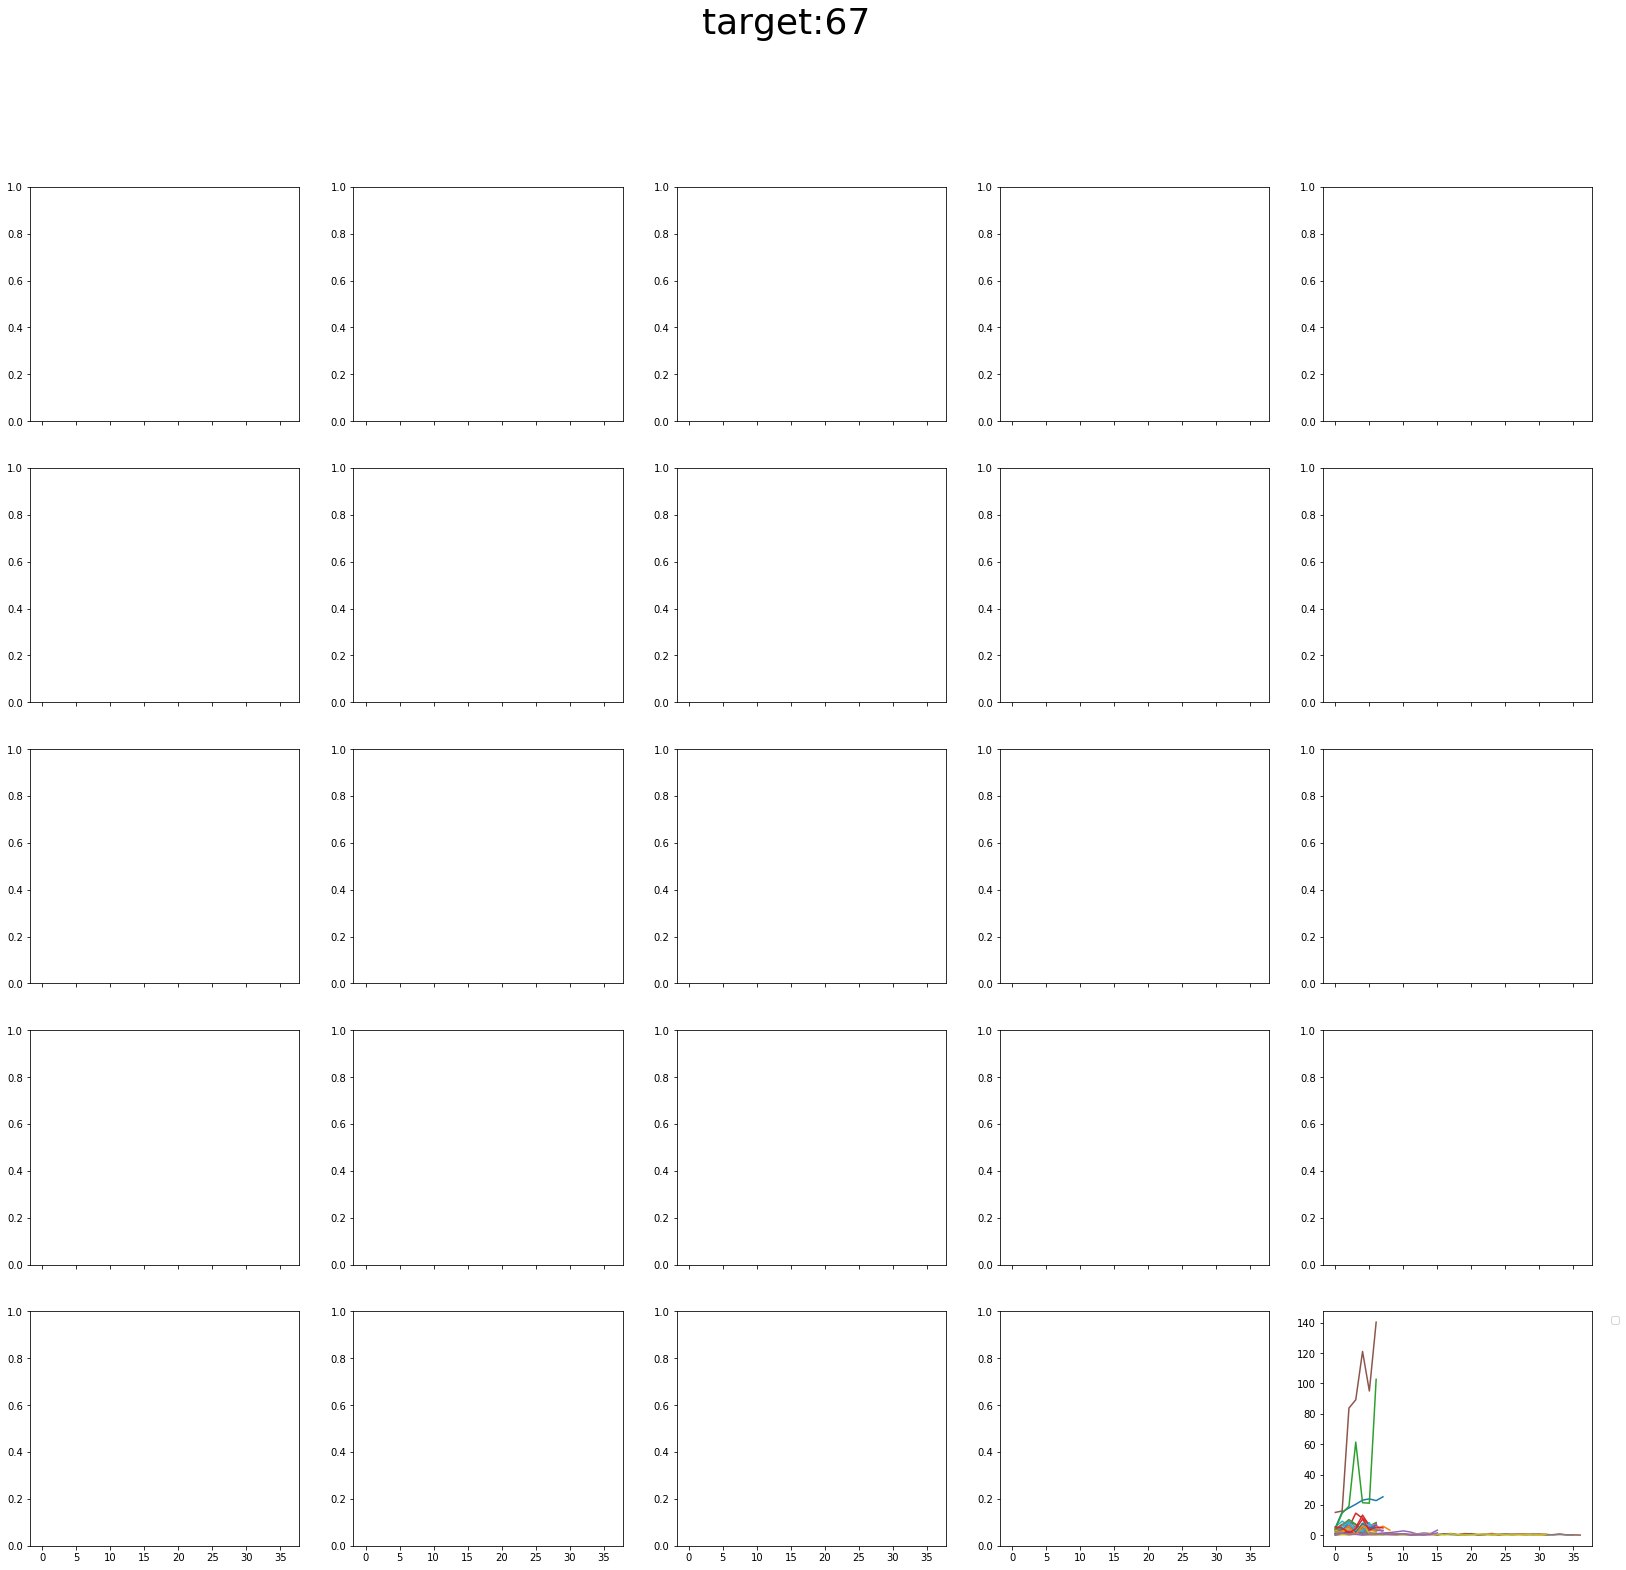

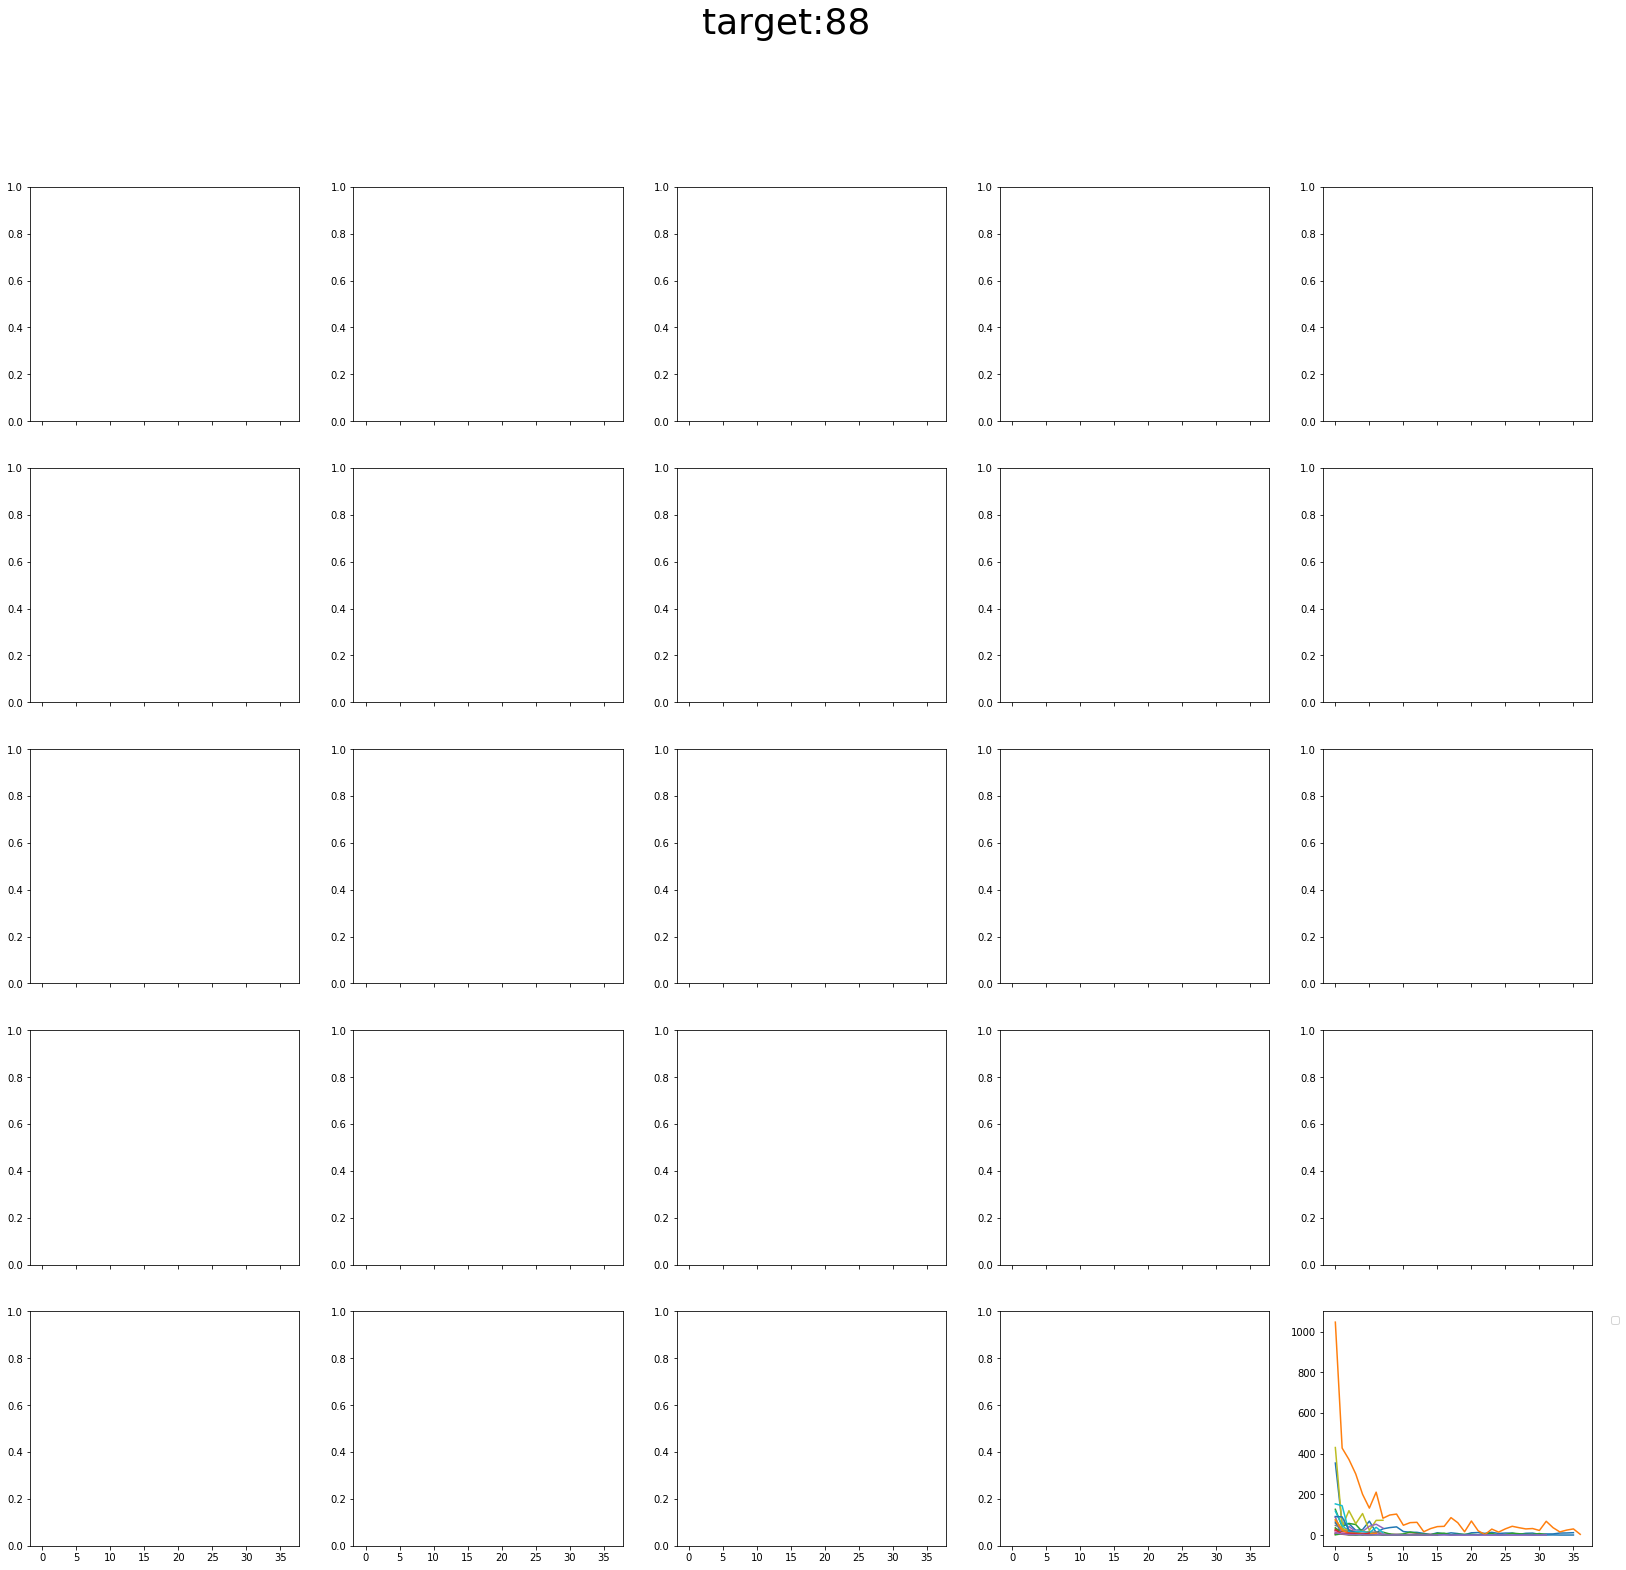

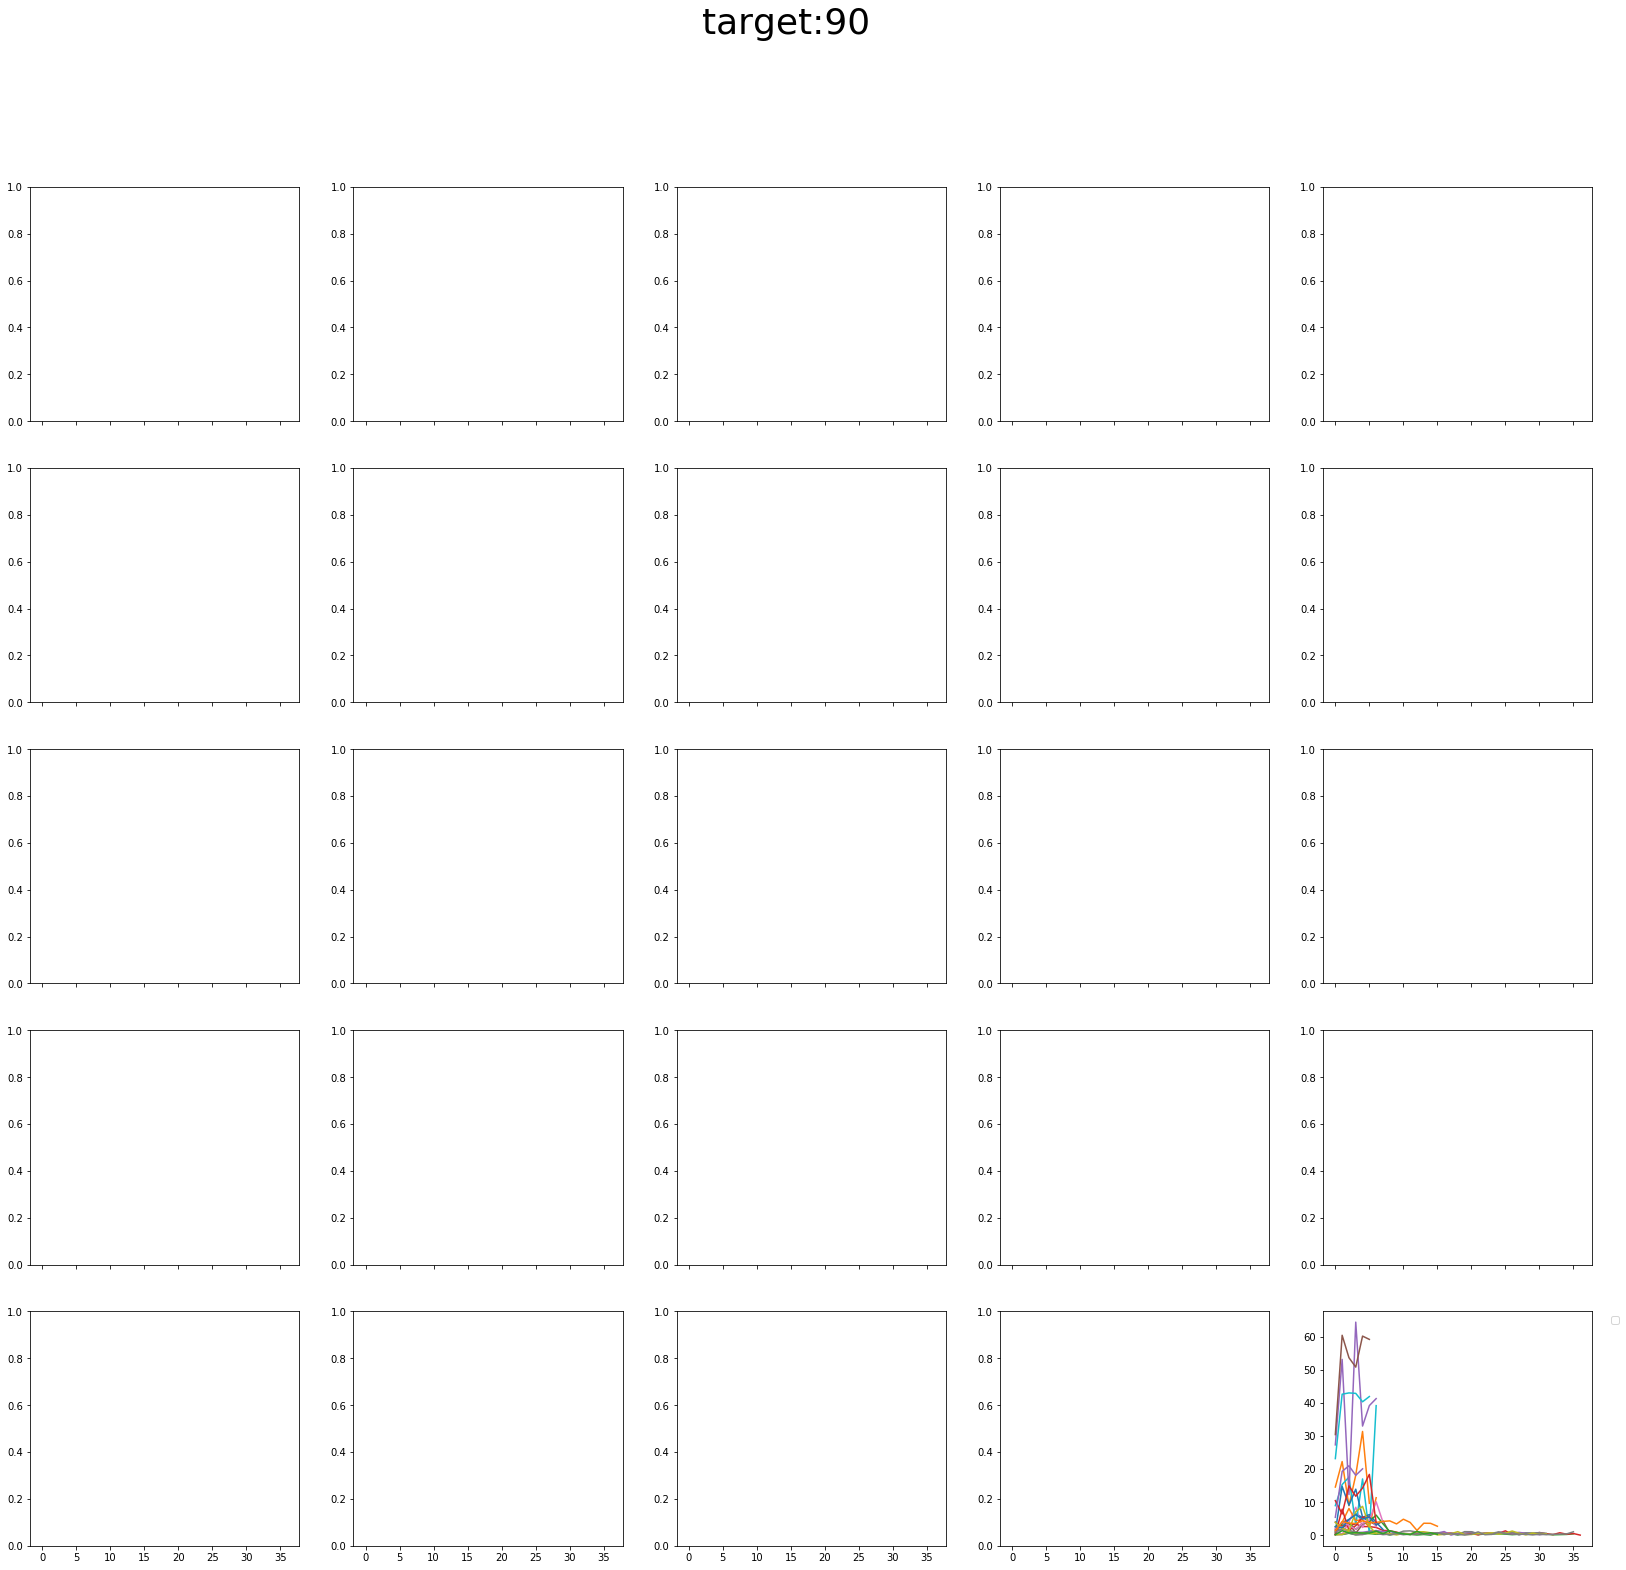

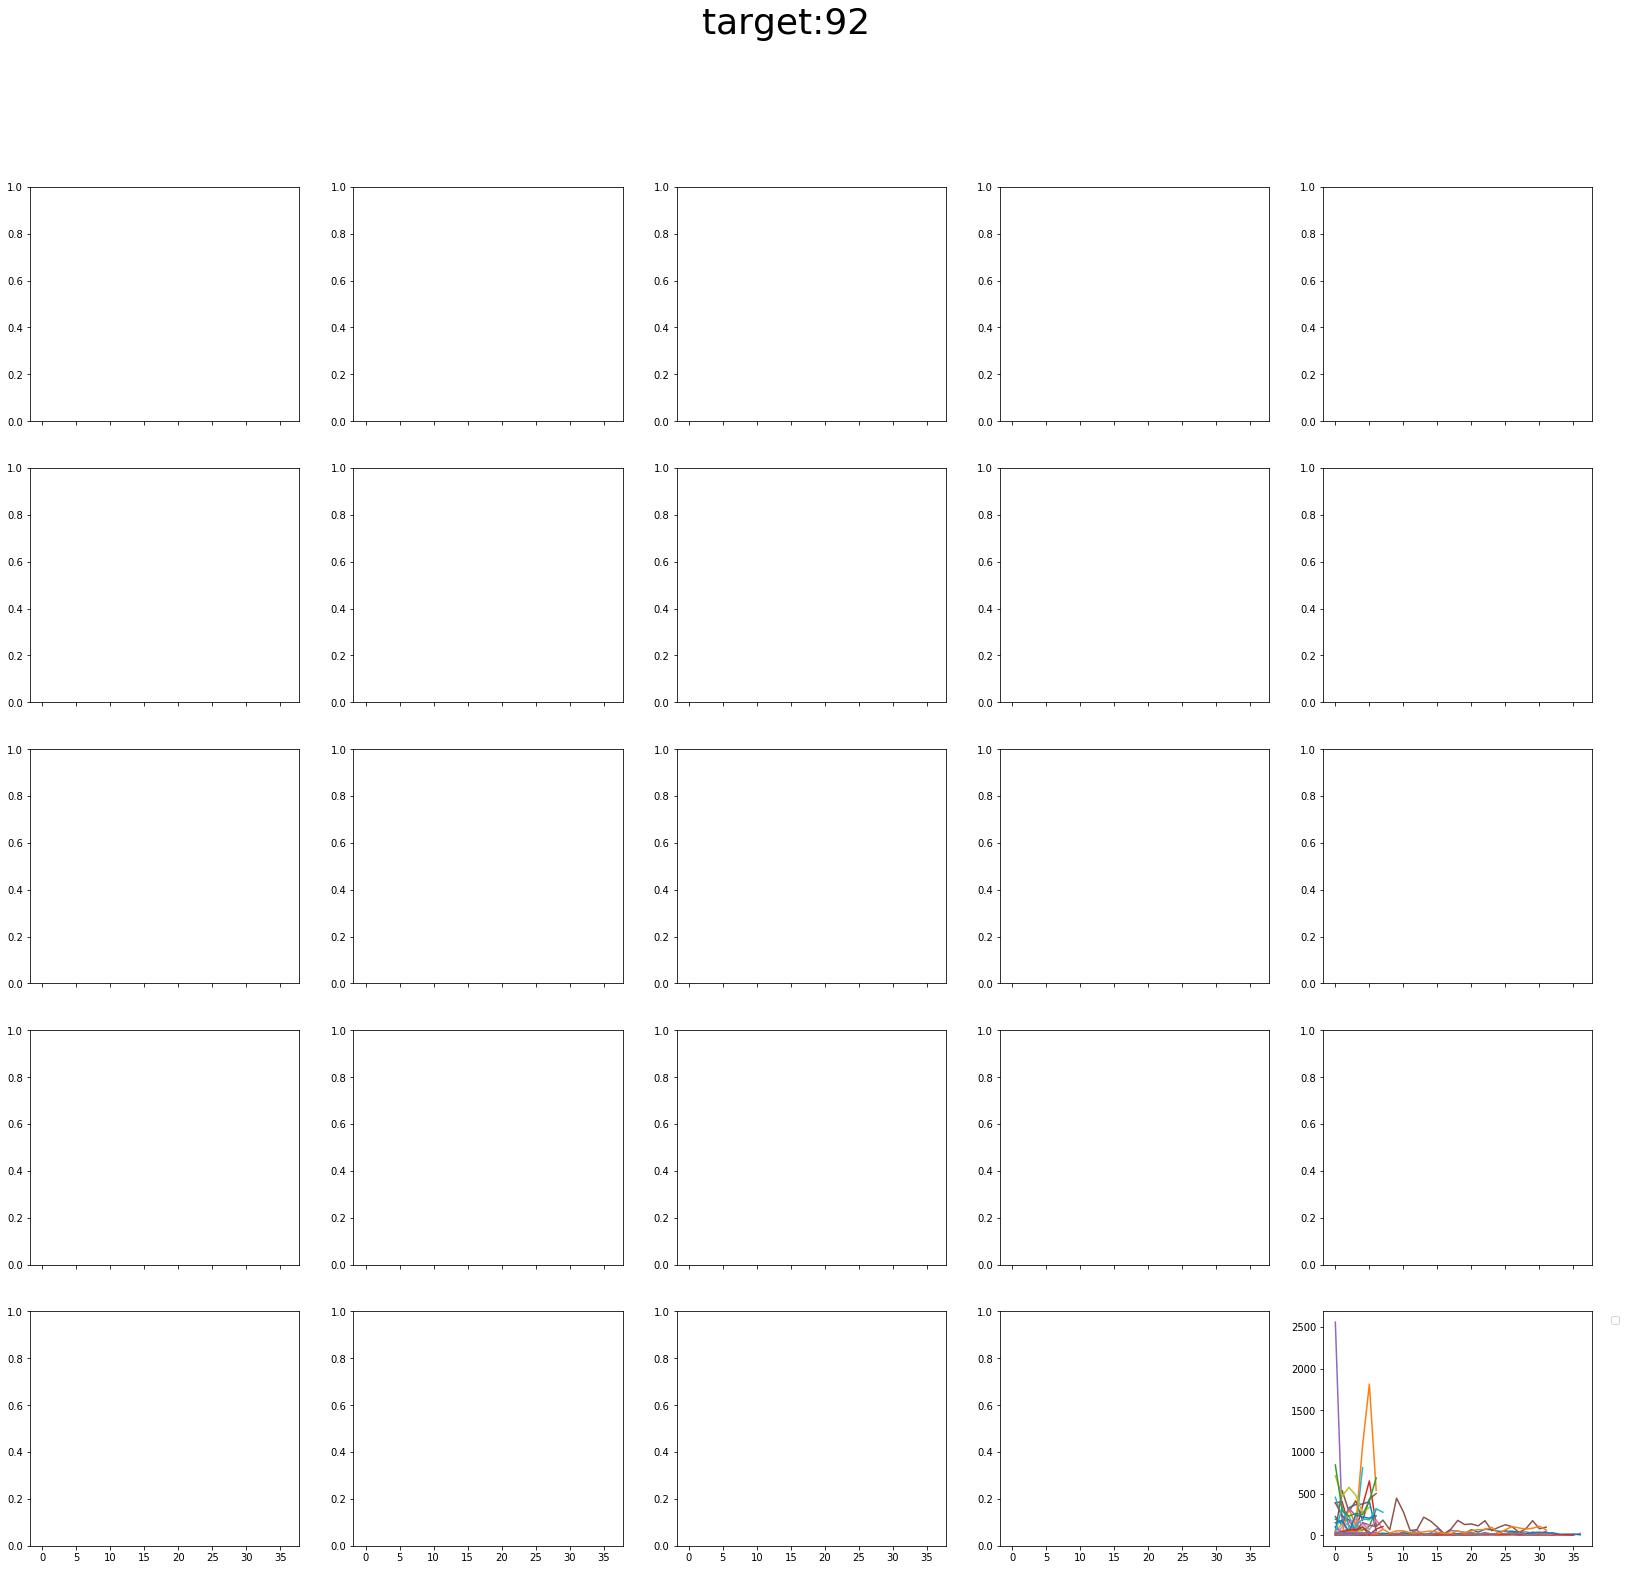

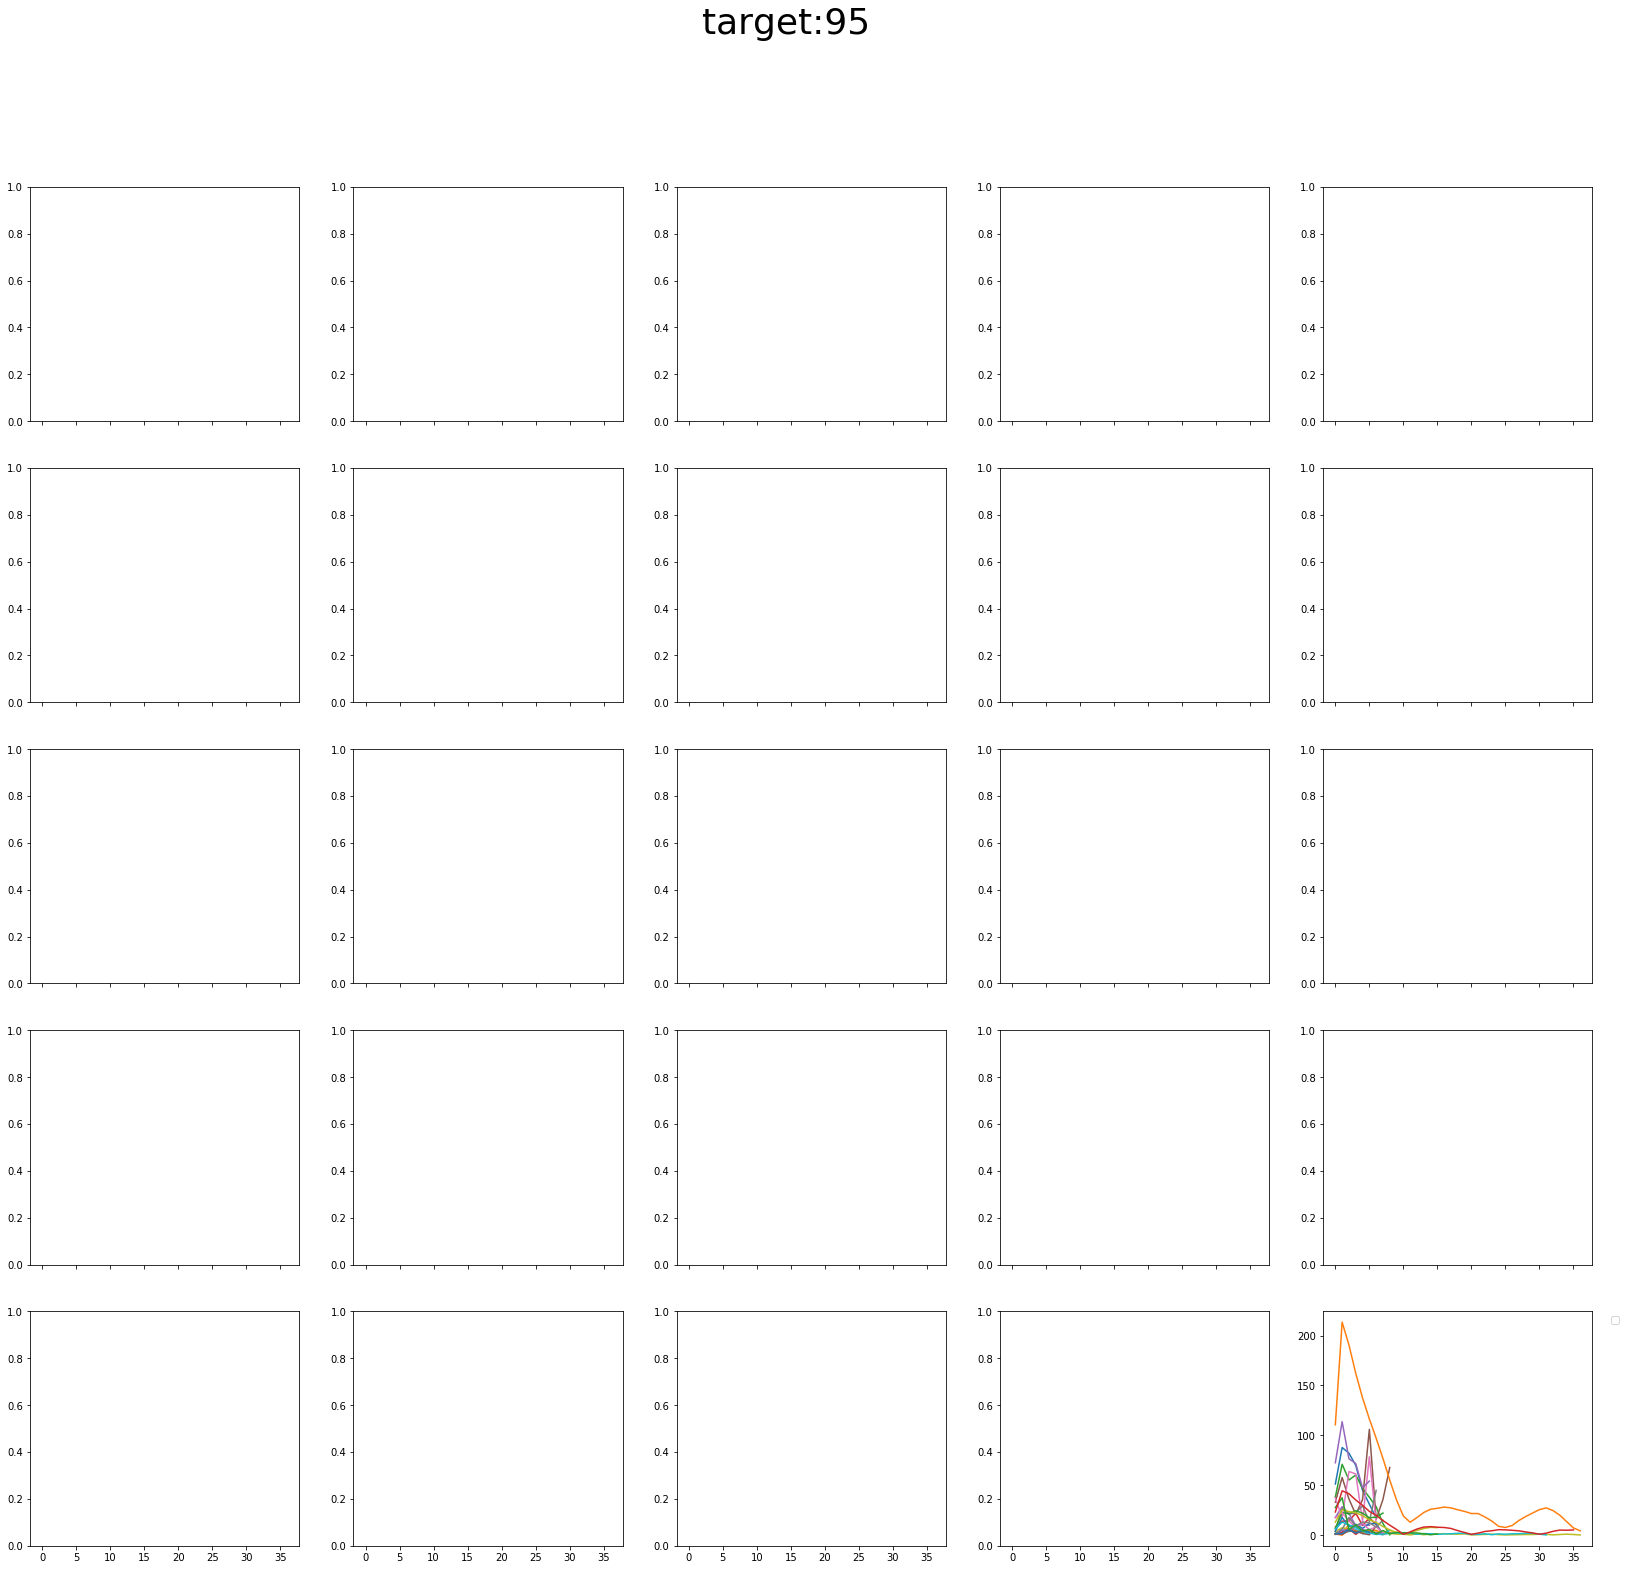

In [16]:
classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
M, N = 5, 5
for c in tqdm(classes):
    li = tr[tr.target==c].sample(M*N).object_id.tolist()
    fig, axes = plt.subplots(ncols=M, nrows=N, figsize=(28, 25), sharex=True)
    
    # プロット
    for i,(ax, oid) in enumerate(zip(axes.ravel(), li)):
        plt_obj(oid, 0)
    
    fig.suptitle(f'target:{c}', fontsize=36)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')